Lambda School Data Science

*Unit 2, Sprint 3, Module 1*

---


# Day 1:  Define ML problems

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your decisions.

- [✓] Choose your target. Which column in your tabular dataset will you predict?
        A: target = 'is_churn'

- [✓] Is your problem regression or classification?
        A:  Binary classification + also focus on predicted probabilities (predict_proba, non-binary)

- [✓] How is your target distributed?
    - Classification: How many classes? Are the classes imbalanced?


            A:  Highly imbalanced: 94% did not churn ('is_churn' == 0), while 6% did churn in Feb. 2017.  This makes sense considering 6% of your total subscribers churning every month is not low -- if it was e.g., 50%, the business would collapse in 1-2 months.  Will take a look at class_balance params, but given there are still many more 'is_churn'=1 observations than I need, I most likely will not try to change this balance when sampling.  Instead, I will focus on different metrics -- recall ("hit rate"), false negative rate (FNR or "miss rate") and log loss -- when setting up my predictive model(s).
    
    - Regression: Is the target right-skewed? If so, you may want to log transform the target.
- [✓] Choose which observations you will use to train, validate, and test your model.
    - Are some observations outliers? Will you exclude them?
    - Will you do a random split or a time-based split?
        

            A:  A time-based split.  I am using the separate March 2017 datasets as the test sets, and not touching them during the predictive modeling process, in order to avoid any leakage.
        

- [✓] Choose your evaluation metric(s).
    - Classification: Is your majority class frequency > 50% and < 70% ? If so, you can just use accuracy if you want. Outside that range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?

            A:  94% of the observations in the training set are in my majority class and did not churn in Feb. 2017 ('is_churn' == 0), while 6% did churn in Feb. 2017.  As such, accuracy is unlikely to be useful -- a dummy majority classifier baseline is already 94% accurate, BUT has 0.0 recall.  With this problem, our priority is to predict what probability each user has of churning "next" month and identify those users we predict will churn, so our customer retention and/or sales team(s) can try to better engage those users.  So it is most important to successfully predict all/most of the users who will churn (high recall), and false positives are actually not too problematic (we can accept lower precision if doing so will increase our recall).  As such, the metrics I will use for evaluating my models are:
            
            (1) recall ("hit rate"), 
            
            (2) false negative rate (FNR or "miss rate"), and 
            
            (3) log loss -- when setting up my predictive model(s).


- [✓] Begin to clean and explore your data.


- [✓] Begin to choose which features, if any, to exclude. Would some features "leak" future information?

Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Day 2:  Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [✓] If you haven't completed assignment #1, please do so first.
- [✓] Continue to clean and explore your data. Make exploratory visualizations.
- [✓] Fit a model. Does it beat your baseline? 
- [✓] Try xgboost.
- [✓] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.

# **Setup + Import Dataset:**

In [2]:
# Import libraries used:
import pandas as pd
import numpy as np

import re
import datetime as dt
from scipy.stats import randint as sp_randint, uniform as sp_uniform  # randint = uniform discrete random variable, uniform = uniform continuous random variable

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, log_loss

In [5]:
# !unzip kaggle_kkbox_source_files.zip

In [6]:
# [?? To do:  Unzip .7z files to get .csv files ??]

In [7]:
# Make working_data (training + val) and test dataframes:
working_data = pd.read_csv('train.csv')
test_all = pd.read_csv('train_v2.csv')

# Make other dataframes (to merge with train and test):
members_all = pd.read_csv('members_v3.csv')
transactions_all = pd.read_csv('transactions.csv')
transactions_all_test = pd.read_csv('transactions_v2.csv')

# Combine all transactions into one dataframe (since we will need to filter by date later anyway to prevent leakage):
transactions_all = pd.concat([transactions_all, transactions_all_test])

In [8]:
# WARNING!:  These are 30.5 GB and 1.4 GB files -- run this cell only when 
# necessary!
%time user_logs_all = pd.read_csv('user_logs.csv')
%time user_logs_all_test = pd.read_csv('user_logs_v2.csv')

# Combine all user_logs into one dataframe (since we will need to filter by date later anyway to prevent leakage):
%time user_logs_all = pd.concat([user_logs_all, user_logs_all_test])

CPU times: user 4min 59s, sys: 4min 45s, total: 9min 44s
Wall time: 13min 30s
CPU times: user 22.4 s, sys: 12.4 s, total: 34.8 s
Wall time: 38.2 s
CPU times: user 24.4 s, sys: 1min 59s, total: 2min 23s
Wall time: 3min 59s


In [9]:
# Reset indices to remove duplicate numbers:
transactions_all.reset_index(inplace=True, drop=True)
user_logs_all.reset_index(inplace=True, drop=True)

In [10]:
# Drop unused information from massive user_logs dataframe (410 mn observations!!):
# We currently are not using any listening data from before July 2016, so we can remove all 
# 2015/01-2016/06 observations for now:
user_logs_all = user_logs_all[user_logs_all['date'] >= 20160701]

In [11]:
# First-level data cleaning: Eliminate completely implausible values, etc.:

# Data cleaning for members dataframe:
members_all['bd'] = members_all['bd'].mask(members_all['bd'] < 10.0, np.NaN)
members_all['bd'] = members_all['bd'].mask(members_all['bd'] > 100.0, np.NaN)
members_all['registered_via'] = members_all['registered_via'].replace({-1: np.NaN})

# Data cleaning for transactions df:
transactions_all['membership_expire_date'] = transactions_all['membership_expire_date'].mask(transactions_all['membership_expire_date'] < transactions_all['membership_expire_date'].quantile(0.0001), np.NaN)
transactions_all['membership_expire_date'] = transactions_all['membership_expire_date'].mask(transactions_all['membership_expire_date'] > transactions_all['membership_expire_date'].quantile(0.9999), np.NaN)

# Data cleaning for user_logs df:
user_logs_all = user_logs_all[(user_logs_all['total_secs'] < user_logs_all['total_secs'].quantile(0.9995))
                             & (user_logs_all['num_25'] < user_logs_all['num_25'].quantile(0.9995))
                             & (user_logs_all['num_50'] < user_logs_all['num_50'].quantile(0.9995))
                             & (user_logs_all['num_75'] < user_logs_all['num_75'].quantile(0.9995))
                             & (user_logs_all['num_985'] < user_logs_all['num_985'].quantile(0.9995))
                             & (user_logs_all['num_100'] < user_logs_all['num_100'].quantile(0.9995))
                             ]


In [12]:
# Split working_data into train and val sets (necessary to split here in addition to CV below, because 
# train has rebalanced classes, but we want to evaluate on val, test with original imbalanced classes):
train_all, val_all = train_test_split(working_data, 
                                      train_size=0.75, 
                                      shuffle=True, 
                                      stratify=working_data['is_churn'], 
                                      random_state=42
                                     )

In [13]:
working_data.shape

(992931, 2)

In [14]:
train_all.shape, val_all.shape, test_all.shape

((744698, 2), (248233, 2), (970960, 2))

In [15]:
members_all.shape, transactions_all.shape, user_logs_all.shape

((6769473, 6), (22978755, 9), (155149646, 9))

# !!! DON'T RERUN ABOVE THIS !!!  
(takes 10 years to run...)

### Subsets:  Take random sample to get subset of data (otherwise too large a dataset to work with efficiently):

In [385]:
# [?? To do: Add a learning curve chart to decide how much of train and val to use, and show why ??]

In [386]:
# Subsets:  Take IID random subsamples of train, val, test that are small enough to work with.
# train_all, val_all, test_all are all to big to work with.

num_to_sample = 2000 # [?? To do: Change to 15-20k or so ??]

# Straight samples mirroring original target variable distribution (keep class imbalance):
train_imbalanced = train_all.sample(n=num_to_sample, replace=True, random_state=42)
train_imbalanced.reset_index(inplace=True, drop=True)

val = val_all.sample(n=num_to_sample, replace=True, random_state=42)
val.reset_index(inplace=True, drop=True)

test = test_all.sample(num_to_sample, replace=True, random_state=42)
test.reset_index(inplace=True, drop=True)

In [387]:
# Balanced classes samples from under-sampling the majority class (best approach given we 
# have many more data points than we can use):

from sklearn.utils import shuffle, resample

target = 'is_churn'

ratio = 1/2
balanced_num = int(num_to_sample * ratio)

# Train: train with balanced classes:

not_churn_sample_train = train_all[train_all[target] == 0].sample(n=balanced_num, 
                                                                  replace=True, 
                                                                  random_state=42)
yes_churn_sample_train = train_all[train_all[target] == 1].sample(n=balanced_num, 
                                                                  replace=True, 
                                                                  random_state=42)

train = pd.concat([not_churn_sample_train, yes_churn_sample_train])
train = shuffle(train, random_state=42)
train.reset_index(inplace=True, drop=True)

# Val: val_balanced version, just in case we want to use it later for cross-validation:

not_churn_sample_val = val_all[val_all[target] == 0].sample(n=balanced_num, 
                                                            replace=True, 
                                                            random_state=42)
yes_churn_sample_val = val_all[val_all[target] == 1].sample(n=balanced_num, 
                                                            replace=True, 
                                                            random_state=42)

val_balanced = pd.concat([not_churn_sample_val, yes_churn_sample_val])
val_balanced = shuffle(val_balanced, random_state=42)
val_balanced.reset_index(inplace=True, drop=True)

In [388]:
# Make a list of all msno IDs in the new subsets train, val and test, for our data_prep function:
all_subsets_msnos = list(train['msno']) + list(val['msno']) + list(test['msno']) # + list(val_balanced['msno']) + list(train_imbalanced['msno'])

In [389]:
# Take subsets of members, transactions, user_logs for only those users included in the above subsets 
# (otherwise compute time is unfeasibly long, e.g., for all 24.6 mn rows in user_logs):
members = members_all[members_all['msno'].isin(all_subsets_msnos)]
transactions = transactions_all[transactions_all['msno'].isin(all_subsets_msnos)]
user_logs = user_logs_all[user_logs_all['msno'].isin(all_subsets_msnos)]

In [390]:
train.shape, val.shape, test.shape

((2000, 2), (2000, 2), (2000, 2))

In [391]:
members.shape, transactions.shape, user_logs.shape

((5327, 6), (97383, 9), (645440, 9))

In [392]:
train.head()

msno  is_churn
0  VoC/tkOpx5rSrD5jfelSls8gv24qJ2IwY2+FfK7tK/s=         1
1  poXelk4L2lJRYUudjtpiyKsCWYNWf3gdfHYkXs98ylA=         0
2  RUC5EU2eXOuDYawBez0KcY1tKWe6l0UvzG4F9nDs2AI=         1
3  J1ySpIEtHy5/fHbMOkx69ZWI/XbW2EpGo09f473gDDM=         0
4  7J8I9mhPRDQJvlegKfyEhBrzSll+hrCObf5wPpPI0RQ=         1

In [393]:
val.head()

msno  is_churn
0  Bu3vaBx1CkanJ9UmbJk70x3qIc1WBkVeOkGGwB+FAVc=         0
1  Zx6c9VSBnj0O8L4SuNXpu/yV5QYo7XSvv1VjSImaF7k=         0
2  j9T1MdUTuRCURN/TPotX1b2Jhd6uGChCF63RbkVToZI=         0
3  KAmIIc7EsTcjkqc16YmKJsdfAoUBN2NzJLSiej5TFt4=         1
4  gp5uBnYOMtyCH0I0OWD+TdSp3cSeD13gJHotGtf1wiY=         0

In [394]:
test.head()

msno  is_churn
0  EbMqBply0dkY1HpfE7EaZSkjP+k4zb2OTnX1jp57WC0=         0
1  LEUnZ/CSq5XOQTRAy0gpdtSeJIpDHsLdWzgbZ4ZbxUM=         0
2  arrNOS52gp074Cvge+dEOBNF1md0JJ/iweM6brfZ+0c=         0
3  VektVJLpDqBZWwHIEV1ZVnq5OFFdyWrkQiyeFwGeAEk=         0
4  Q8eDeUpFEpQhTrsEWkGA+0IUxwru76i4cBsruzPTJeo=         0

In [395]:
members.head()

msno  city    bd  gender  \
309   0uAjNEzX6IY+lZ+PYv9W31mZjHxUWkbFz9LL8m9G46k=    15  23.0  female   
645   UXmaug3gaadL7IPD+liAWEObCyiwGERi1cU/I0TN3Ik=     1   NaN     NaN   
1068  oXrWnFQd/ZhkZ/8s3j8bRHH7ucPGlFJYWTh34RCf9uM=     1   NaN     NaN   
1699  Sf8eYP3kQPUu8NqfM/sXi1MD+mS1lQzMXkwLPMdm6MU=     1   NaN     NaN   
3452  gLGjby2Ge62IqGu5PGuWA8OFHd7HenAZVaUcH7SKPIc=    13  20.0  female   

      registered_via  registration_init_time  
309              7.0                20141103  
645              9.0                20161231  
1068             7.0                20170121  
1699             7.0                20111007  
3452             3.0                20130204

In [396]:
transactions.head()

msno  payment_method_id  \
19   Qw6UVFUknPVOLxSSsejinxU/8a5/AgmiWMvPoEt0rik=                 39   
114  jyA9StM/2EHPefRmJxHn5ryWxCQiP+PS2/FYNG5K3KI=                 37   
568  FVwf2pTZlDKiF7qYRt79o5aNSYhpq8gGIla9Kduouj0=                 41   
789  hjt3RjBq/exmoe7thjBOd9mfZ8PBpZrJuPK6VFIo3qk=                 41   
793  TKfTjSaGzQW8vP5ao8q6qQstlmXh/2Z0NgkeErzlxIA=                 37   

     payment_plan_days  plan_list_price  actual_amount_paid  is_auto_renew  \
19                  30              149                 149              1   
114                 31              149                 149              1   
568                 30               99                  99              1   
789                 30               99                  99              1   
793                 30              149                 149              1   

     transaction_date  membership_expire_date  is_cancel  
19           20150930              20151108.0          0  
114          20150131              20150301.0          0  
568          20161202              20170102.0          0  
789          20160106              20160206.0          0  
793          20160107              20160206.0          0

In [397]:
user_logs.head()

msno      date  num_25  num_50  \
5004  p7PU+C7m/0PorTCal7EH1MWflSreI7Hwd3831rmcs1E=  20160816       4       4   
5005  p7PU+C7m/0PorTCal7EH1MWflSreI7Hwd3831rmcs1E=  20161006       2       1   
5006  p7PU+C7m/0PorTCal7EH1MWflSreI7Hwd3831rmcs1E=  20161201       0       1   
5007  p7PU+C7m/0PorTCal7EH1MWflSreI7Hwd3831rmcs1E=  20170202       7       1   
5085  Vvb4NqBq8IvA3ETiHEK+BZFZoWJTF9L4JBoU/ezCqIw=  20160726       3       2   

      num_75  num_985  num_100  num_unq  total_secs  
5004       0        1       99       27   17916.371  
5005       1        1      109      105   21316.326  
5006       1        0      108       47   23194.040  
5007       0        1      110       38   18250.990  
5085       0        0       90       92   21316.387

# **Data Prep. & Feature Engineering:**

In [398]:
# Set the correct cutoff date for the dataset = first day of the renewal period (to prevent data leakage):
cutoff_train = dt.datetime(2017, 2, 1)
cutoff_test = dt.datetime(2017, 3, 1)

In [399]:
train.shape, val.shape, test.shape

((2000, 2), (2000, 2), (2000, 2))

In [400]:
# Data prep. for members, transactions, user_logs:

# Members:
members.loc[:, 'registration_init_time'] = pd.to_datetime(members['registration_init_time'], format='%Y%m%d')
members.rename(columns={'bd': 'age'}, inplace=True)

# Transactions:
# [?? To do... ??]
transactions.loc[:, 'transaction_date'] = pd.to_datetime(transactions['transaction_date'], format='%Y%m%d')
transactions.loc[:, 'membership_expire_date'] = pd.to_datetime(transactions['membership_expire_date'], format='%Y%m%d')
transactions.loc[:, 'actual_amount_paid_per_30_days'] = transactions['actual_amount_paid'] / (transactions['payment_plan_days'] / 30)
transactions['actual_amount_paid_per_30_days'].replace({np.inf: np.NaN}, inplace=True)

# User Logs (listening data):
user_logs.loc[:, 'date'] = pd.to_datetime(user_logs['date'], format='%Y%m%d')

/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/pandas/core/frame.py:4238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead


In [401]:
# Function that does all data prep on train, val, test:

def data_prep(dataframe, members, transactions, user_logs, cutoff_date):
    # [?? To do: Best to make copies or no ??]
    df = dataframe.copy()
    members = members.copy()
    transactions = transactions[transactions['transaction_date'] < cutoff_date].copy()
    user_logs = user_logs[user_logs['date'] < cutoff_date].copy()
    
#     cutoff_date = cutoff_date
    date_1_month_ago = cutoff_date + pd.DateOffset(months=-1)
    date_6_months_ago = cutoff_date + pd.DateOffset(months=-6)
    
    # Merge key features into main dataframe:
    df = pd.merge(df, members, how='left', on='msno')
    
    # Main dataframe:  OneHot encoding for 0/1 binary features with NaNs:
    columns_for_onehot = ['gender']
    encoder_onehot = ce.OneHotEncoder(use_cat_names=True)
    encoded_columns_onehot = encoder_onehot.fit_transform(df[columns_for_onehot])
    
#     encoded_columns_onehot['msno'] = df['msno']                       # Add back msno numbers to merge
    df = pd.merge(df, encoded_columns_onehot, how='left', left_index=True, right_index=True)
    
    # NEW FEATURES:
    
    df.loc[:, 'total_days_since_joined'] = (cutoff_date - df['registration_init_time']).dt.days
    
    # More computationally efficient to set these columns as default=NaN, rather than one-by-one as the 
    # elif... part of the below for loop:
    df.loc[:, 'cost_per_month'] = np.NaN
    df.loc[:, 'on_auto_renew'] = np.NaN
    df.loc[:, 'payment_method_latest'] = np.NaN
    df.loc[:, 'churn_returned_in_past'] = np.NaN
    df.loc[:, 'churn_returned_num_times'] = np.NaN
    df.loc[:, 'churned_full_in_past'] = np.NaN
    df.loc[:, 'churned_full_num_times'] = np.NaN
    df.loc[:, 'churned_any_in_past'] = np.NaN
    df.loc[:, 'churned_any_num_times'] = np.NaN

    df.loc[:, 'total_mins_last_month'] = np.NaN
    df.loc[:, 'total_mins_last_6_months'] = np.NaN
    df.loc[:, 'total_mins_last_month'] = np.NaN
    df.loc[:, 'total_mins_last_6_months'] = np.NaN

    df.loc[:, 'num_unique_last_month'] = np.NaN
    df.loc[:, 'num_unique_last_6_months'] = np.NaN
    df.loc[:, 'num_songs_started_last_month'] = np.NaN
    df.loc[:, 'num_songs_started_last_6_months'] = np.NaN
    df.loc[:, 'num_songs_listened_last_month'] = np.NaN
    df.loc[:, 'num_songs_listened_last_6_months'] = np.NaN
    df.loc[:, 'num_songs_finished_last_month'] = np.NaN
    df.loc[:, 'num_songs_finished_last_6_months'] = np.NaN

    df.loc[:, 'songs_affinity_nps_last_month'] = np.NaN
    df.loc[:, 'songs_affinity_nps_last_6_months'] = np.NaN
    df.loc[:, 'songs_percent_loved_last_month'] = np.NaN
    df.loc[:, 'songs_percent_loved_last_6_months'] = np.NaN
    df.loc[:, 'songs_percent_disliked_last_month'] = np.NaN
    df.loc[:, 'songs_percent_disliked_last_6_months'] = np.NaN
    
    df.loc[:, 'active_days_L30_last_month'] = np.NaN
    df.loc[:, 'active_days_L30_last_6_months_avg'] = np.NaN
    df.loc[:, 'is_MAU_last_month'] = np.NaN
    df.loc[:, 'is_WAU_last_month'] = np.NaN
    df.loc[:, 'is_WAU_last_6_months'] = np.NaN
    df.loc[:, 'is_DAU_last_month'] = np.NaN
    df.loc[:, 'is_DAU_last_6_months'] = np.NaN
    
    for row_num in df.index:
        msno = df.loc[row_num, 'msno']

        # ------------------------ TRANSACTIONS/SUBSCRIPTION FEATURES -------------------------------------------
        
        # User's transactions history: pull in useful data from transactions logs:
        transactions_this_user = transactions[transactions['msno'] == msno].sort_values(by='transaction_date', ascending=True)
#         txns_last_month = transactions_this_user[transactions_this_user['transaction_date'] > date_1_month_ago]
#         txns_last_6_months = transactions_this_user[transactions_this_user['transaction_date'] > date_6_months_ago]

        # New features for transactions/subscription history:
        if msno in set(transactions['msno']):
            df.loc[row_num, 'cost_per_month'] = transactions_this_user.iloc[-1]['actual_amount_paid_per_30_days']
            df.loc[row_num, 'on_auto_renew'] = transactions_this_user.iloc[-1]['is_auto_renew']
            df.loc[row_num, 'payment_method_latest'] = transactions_this_user.iloc[-1]['payment_method_id']

            # Make features for 'has churned before' and 'churned before # times':
            cancellations = transactions_this_user[transactions_this_user['is_cancel'] == 1]['transaction_date']
            churn_returned_num_times = 0
            churned_full_num_times = 0
            for cancel_event in cancellations:
                # Check whether: 
                # (a) simply upgraded subscription type (didn't churn); 
                # (b) half-churned or "churn-returned": ended subscription, but reactivated within 30 days; or 
                # (c) full-churned: ended subscription and did not reactivate within 30 days):
                plan_change_range = [cancel_event + pd.DateOffset(days=-1), cancel_event + pd.DateOffset(days=1)]
                plan_change_conditions = (transactions_this_user['transaction_date'] >= plan_change_range[0]) & (transactions_this_user['transaction_date'] <= plan_change_range[1])
                plan_change = (transactions_this_user[plan_change_conditions]['is_cancel'] == 0).sum() >= 1

                renewed_range = [cancel_event + pd.DateOffset(days=-14), cancel_event + pd.DateOffset(days=30)]
                renewed_conditions = (transactions_this_user['transaction_date'] >= renewed_range[0]) & (transactions_this_user['transaction_date'] <= renewed_range[1])
                renewed = (transactions_this_user[renewed_conditions]['is_cancel'] == 0).sum() >= 1

                if renewed == True & plan_change == False:
                    churn_returned_num_times += 1
                elif renewed == False:
                    churned_full_num_times += 1
                # elif renewed == True & plan_change == True:
                    # User simply changed plans (upgraded/downgraded) --> no churn event at all.

            df.loc[row_num, 'churn_returned_in_past'] = churn_returned_num_times >= 1
            df.loc[row_num, 'churn_returned_num_times'] = churn_returned_num_times
            df.loc[row_num, 'churned_full_in_past'] = churned_full_num_times >= 1
            df.loc[row_num, 'churned_full_num_times'] = churned_full_num_times
            df.loc[row_num, 'churned_any_in_past'] = (churn_returned_num_times + churned_full_num_times) >= 1
            df.loc[row_num, 'churned_any_num_times'] = churn_returned_num_times + churned_full_num_times
        
        # ------------------------ LISTENING/USAGE FEATURES -----------------------------------------------------
        
        # User's listening history: pull in useful data for that user from user_logs (listening data):
        listening_logs_this_user = user_logs[user_logs['msno'] == msno].sort_values(by='date', ascending=True)
        logs_last_month = listening_logs_this_user[listening_logs_this_user['date'] > date_1_month_ago]
        logs_last_6_months = listening_logs_this_user[listening_logs_this_user['date'] > date_6_months_ago]

        # New features re the user's listening behavior/history:
        
        # Make INTs for these values --> saves compute time below (vs. df lookup in train, val, test 50+ times for every row):
        num_25_last_month = logs_last_month['num_25'].sum()
        num_50_last_month = logs_last_month['num_50'].sum()
        num_75_last_month = logs_last_month['num_75'].sum()
        num_985_last_month = logs_last_month['num_985'].sum()
        num_100_last_month = logs_last_month['num_100'].sum()

        num_25_last_6_months = logs_last_6_months['num_25'].sum()
        num_50_last_6_months = logs_last_6_months['num_50'].sum()
        num_75_last_6_months = logs_last_6_months['num_75'].sum()
        num_985_last_6_months = logs_last_6_months['num_985'].sum()
        num_100_last_6_months = logs_last_6_months['num_100'].sum()

        num_songs_started_last_month = num_25_last_month + num_50_last_month + num_75_last_month + num_985_last_month + num_100_last_month
        num_songs_started_last_6_months = num_25_last_6_months + num_50_last_6_months + num_75_last_6_months + num_985_last_6_months + num_100_last_6_months

        if df.loc[row_num, 'msno'] in set(user_logs['msno']):
            df.loc[row_num, 'total_mins_last_month'] = logs_last_month['total_secs'].sum() / 60
            df.loc[row_num, 'total_mins_last_6_months'] = logs_last_6_months['total_secs'].sum() / 60
            df.loc[row_num, 'num_unique_last_month'] = logs_last_month['num_unq'].sum()
            df.loc[row_num, 'num_unique_last_6_months'] = logs_last_6_months['num_unq'].sum()
            df.loc[row_num, 'num_songs_started_last_month'] = num_25_last_month + num_50_last_month + num_75_last_month + num_985_last_month + num_100_last_month
            df.loc[row_num, 'num_songs_started_last_6_months'] = num_25_last_6_months + num_50_last_6_months + num_75_last_6_months + num_985_last_6_months + num_100_last_6_months
            df.loc[row_num, 'num_songs_listened_last_month'] = num_75_last_month + num_985_last_month + num_100_last_month
            df.loc[row_num, 'num_songs_listened_last_6_months'] = num_75_last_6_months + num_985_last_6_months + num_100_last_6_months
            df.loc[row_num, 'num_songs_finished_last_month'] = num_100_last_month
            df.loc[row_num, 'num_songs_finished_last_6_months'] = num_100_last_6_months

            df.loc[row_num, 'songs_affinity_nps_last_month'] = (num_985_last_month + num_100_last_month - num_25_last_month - num_50_last_month) / num_songs_started_last_month
            df.loc[row_num, 'songs_affinity_nps_last_6_months'] = (num_985_last_6_months + num_100_last_6_months - num_25_last_6_months - num_50_last_6_months) / num_songs_started_last_6_months
            df.loc[row_num, 'songs_percent_loved_last_month'] = (num_985_last_month + num_100_last_month) / num_songs_started_last_month
            df.loc[row_num, 'songs_percent_loved_last_6_months'] = (num_985_last_6_months + num_100_last_6_months) / num_songs_started_last_6_months
            df.loc[row_num, 'songs_percent_disliked_last_month'] = num_25_last_month / num_songs_started_last_month
            df.loc[row_num, 'songs_percent_disliked_last_6_months'] = num_25_last_6_months / num_songs_started_last_6_months
            
            # Active usage metrics (D/W/MAU is daily/weekly/monthly active user):
            df.loc[row_num, 'active_days_L30_last_month'] = logs_last_month.shape[0]
            df.loc[row_num, 'active_days_L30_last_6_months_avg'] = logs_last_6_months.shape[0] / 6
            if df.loc[row_num, 'registration_init_time'] < date_6_months_ago:
                df.loc[row_num, 'is_WAU_last_6_months'] = df.loc[row_num, 'active_days_L30_last_6_months_avg'] >= (6/12*52)
                df.loc[row_num, 'is_DAU_last_6_months'] = df.loc[row_num, 'active_days_L30_last_6_months_avg'] >= (6*30*5/7)
    
    # Also user listening data like above, but just more computationally efficient outside of the above for loop:
    df.loc[:, 'is_MAU_last_month'] = df['active_days_L30_last_month'] >= 1
    df.loc[:, 'is_WAU_last_month'] = df['active_days_L30_last_month'] >= 5
    df.loc[:, 'is_DAU_last_month'] = df['active_days_L30_last_month'] >= (30*5/7)
    df.loc[:, 'avg_min_per_song'] = df['total_mins_last_month'] / df['num_songs_started_last_month']
    df.loc[:, 'last_6_months_avg_monthly_mins'] = df['total_mins_last_6_months'] / 6
    df.loc[:, 'last_month_vs_6_month_avg'] = df['total_mins_last_month'] / df['last_6_months_avg_monthly_mins']
    
    return df

In [402]:
# Do data prep on train, val, test:
%time train = data_prep(train, members, transactions, user_logs, cutoff_train)
%time val = data_prep(val, members, transactions, user_logs, cutoff_train)
# %time test = data_prep(test, members, transactions, user_logs, cutoff_test)

/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:158: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:155: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:157: RuntimeWarning: invalid value encountered in long_scalars
/Users/huskeycl/anaconda3/envs/unit2/lib/python3.7/site-packages/ipykernel_launcher.py:159: RuntimeWarning: invalid value encountered in long_scalars


CPU times: user 6min 53s, sys: 5.47 s, total: 6min 58s
Wall time: 7min 5s
CPU times: user 6min 57s, sys: 2.34 s, total: 6min 59s
Wall time: 7min 4s


In [403]:
# [?? To do: Need to add msnos from val_balanced and train_imbalanced to all_subsets_msnos 
# above before can run this cell!! ??]

# %%time 
# val_balanced = data_prep(val_balanced, members, transactions, user_logs, cutoff_train)

In [404]:
# [?? To do: Need to add msnos from val_balanced and train_imbalanced to all_subsets_msnos 
# above before can run this cell!! ??]

# %%time 
# train_imbalanced = data_prep(train_imbalanced, members, transactions, user_logs, cutoff_train)

In [405]:
train

msno  is_churn  city   age  \
0     VoC/tkOpx5rSrD5jfelSls8gv24qJ2IwY2+FfK7tK/s=         1  13.0  26.0   
1     poXelk4L2lJRYUudjtpiyKsCWYNWf3gdfHYkXs98ylA=         0   1.0   NaN   
2     RUC5EU2eXOuDYawBez0KcY1tKWe6l0UvzG4F9nDs2AI=         1   4.0  18.0   
3     J1ySpIEtHy5/fHbMOkx69ZWI/XbW2EpGo09f473gDDM=         0   1.0   NaN   
4     7J8I9mhPRDQJvlegKfyEhBrzSll+hrCObf5wPpPI0RQ=         1   5.0  20.0   
...                                            ...       ...   ...   ...   
1995  Rrr/UlncgqTxXD9cpGN1GsCaVjM35AGoIZVq8aIC0Lc=         1   1.0   NaN   
1996  aWOGVPMwjLMux4Ga8+gPcZcAUoEldwZbe163FO237MQ=         1   5.0  20.0   
1997  IEuNtYtW/Fix6BBBMWKxPsK+dkEvYmejtXRNSXOATF8=         0   1.0   NaN   
1998  yOBm+kyVQ2ufe8mTcwJouzRrhWGZRLGaE/m2akEo7kc=         1   4.0   NaN   
1999  Y+rrOcPMTOKhq5nPWhpENx8bjThS663wKrtf0WX+msU=         1   1.0   NaN   

      gender  registered_via registration_init_time  gender_male  gender_nan  \
0       male             4.0             2016-04-09            1           0   
1        NaN             7.0             2016-11-30            0           1   
2       male             3.0             2014-09-06            1           0   
3        NaN             7.0             2012-01-14            0           1   
4       male             9.0             2015-06-16            1           0   
...      ...             ...                    ...          ...         ...   
1995     NaN             7.0             2012-12-26            0           1   
1996  female             4.0             2016-06-03            0           0   
1997     NaN             7.0             2013-10-09            0           1   
1998     NaN             9.0             2015-12-27            0           1   
1999     NaN             4.0             2015-10-24            0           1   

      gender_female  ...  active_days_L30_last_month  \
0                 0  ...                         0.0   
1                 0  ...                        16.0   
2                 0  ...                        28.0   
3                 0  ...                         0.0   
4                 0  ...                        16.0   
...             ...  ...                         ...   
1995              0  ...                        30.0   
1996              1  ...                         6.0   
1997              0  ...                        22.0   
1998              0  ...                        11.0   
1999              0  ...                        29.0   

      active_days_L30_last_6_months_avg  is_MAU_last_month  is_WAU_last_month  \
0                              1.000000              False              False   
1                              6.000000               True               True   
2                             28.833333               True               True   
3                              0.166667              False              False   
4                             17.500000               True               True   
...                                 ...                ...                ...   
1995                           7.000000               True               True   
1996                          14.166667               True               True   
1997                          23.000000               True               True   
1998                          22.333333               True               True   
1999                          11.666667               True               True   

     is_WAU_last_6_months  is_DAU_last_month is_DAU_last_6_months  \
0                   False              False                False   
1                     NaN              False                  NaN   
2                    True               True                False   
3                   False              False                False   
4                   False              False                False   
...                   ...                ...                  ...   
1995                False               Tru

In [406]:
val

msno  is_churn  city   age  \
0     Bu3vaBx1CkanJ9UmbJk70x3qIc1WBkVeOkGGwB+FAVc=         0   1.0   NaN   
1     Zx6c9VSBnj0O8L4SuNXpu/yV5QYo7XSvv1VjSImaF7k=         0   NaN   NaN   
2     j9T1MdUTuRCURN/TPotX1b2Jhd6uGChCF63RbkVToZI=         0   4.0  30.0   
3     KAmIIc7EsTcjkqc16YmKJsdfAoUBN2NzJLSiej5TFt4=         1   1.0   NaN   
4     gp5uBnYOMtyCH0I0OWD+TdSp3cSeD13gJHotGtf1wiY=         0   1.0   NaN   
...                                            ...       ...   ...   ...   
1995  HnUctZ0Fxl0Ss5Yi3bJeAOEBRtqe29HGdLFa/ofcI6I=         0   7.0   NaN   
1996  LesztFi5GIqq8GsJej6LMysE6U0ATkGCaoCATYebzb8=         0   4.0  40.0   
1997  ydpshRYSuy9s+/iHGMKSxfpJSiVki6CoBzgYUw7xE7A=         0   1.0   NaN   
1998  +iPH8IrKAIA16trjeEfja6AAy9yPfqtelSXpgidQwQ8=         1   5.0  34.0   
1999  Aj3EdhErr0e9DG2Nghlqlpb4d9m7u14UYf1Cy8L/wUI=         0   1.0   NaN   

      gender  registered_via registration_init_time  gender_nan  gender_male  \
0        NaN             4.0             2016-04-29           1            0   
1        NaN             NaN                    NaT           1            0   
2       male             9.0             2011-03-07           0            1   
3        NaN             4.0             2016-04-30           1            0   
4        NaN             7.0             2013-02-03           1            0   
...      ...             ...                    ...         ...          ...   
1995     NaN             9.0             2014-08-13           1            0   
1996    male             9.0             2007-03-05           0            1   
1997     NaN             7.0             2013-02-18           1            0   
1998  female             9.0             2014-02-21           0            0   
1999     NaN            13.0             2016-09-07           1            0   

      gender_female  ...  active_days_L30_last_month  \
0                 0  ...                        29.0   
1                 0  ...                         NaN   
2                 0  ...                        23.0   
3                 0  ...                        15.0   
4                 0  ...                         0.0   
...             ...  ...                         ...   
1995              0  ...                        18.0   
1996              0  ...                         1.0   
1997              0  ...                        30.0   
1998              1  ...                         4.0   
1999              0  ...                        29.0   

      active_days_L30_last_6_months_avg  is_MAU_last_month  is_WAU_last_month  \
0                             21.166667               True               True   
1                                   NaN              False              False   
2                             26.333333               True               True   
3                              6.666667               True               True   
4                              3.166667              False              False   
...                                 ...                ...                ...   
1995                          16.666667               True               True   
1996                           1.000000               True              False   
1997                          27.000000               True               True   
1998                           4.166667               True              False   
1999                          22.166667               True               True   

     is_WAU_last_6_months  is_DAU_last_month is_DAU_last_6_months  \
0                   False               True                False   
1                     NaN              False                  NaN   
2                    True               True                False   
3                   False              False                False   
4                   False              False                False   
...                   ...                ...                  ...   
1995                False              Fals

In [407]:
test

msno  is_churn
0     EbMqBply0dkY1HpfE7EaZSkjP+k4zb2OTnX1jp57WC0=         0
1     LEUnZ/CSq5XOQTRAy0gpdtSeJIpDHsLdWzgbZ4ZbxUM=         0
2     arrNOS52gp074Cvge+dEOBNF1md0JJ/iweM6brfZ+0c=         0
3     VektVJLpDqBZWwHIEV1ZVnq5OFFdyWrkQiyeFwGeAEk=         0
4     Q8eDeUpFEpQhTrsEWkGA+0IUxwru76i4cBsruzPTJeo=         0
...                                            ...       ...
1995  g+Sc57/QDyPc7mVg/G0E3+Oe7RSIME5p/RzLyipjsi8=         0
1996  /8qDHfF3C++A/JIuIb1YKd2OgSCxTNqy2zrRyUBpbFg=         0
1997  rEpX47qaImdbYldUgPznFvZynLCC2sOTXF9jL9k9AWs=         0
1998  6ZcLDZWpQJiXw7FFz6LnPGHLAjyZZtuT7keHHAUnnV4=         1
1999  66Qf3IBG2IRtnVku5+8OpTc8EhhCz1grQmVUSwl2VhM=         1

[2000 rows x 2 columns]

**External review only: Export key dataframes as CSVs --> cell that imports/makes new dfs from those CSVs:**

*(i.e., save a ton of time by letting reviewers run a quick test of everything below, without needing to wait 2+ hours for the above data prep. code cells to run):*

In [408]:
# # Save files needed below as CSVs:
# train.to_csv('pre_prepped_data_for_code_reviewers/train_sample.csv')
# val.to_csv('pre_prepped_data_for_code_reviewers/val_sample.csv')
# test.to_csv('pre_prepped_data_for_code_reviewers/test_sample.csv')

# # train_imbalanced.to_csv('pre_prepped_data_for_code_reviewers/train_imbalanced_sample.csv')
# # val_balanced.to_csv('pre_prepped_data_for_code_reviewers/val_balanced_sample.csv')

# members.to_csv('pre_prepped_data_for_code_reviewers/members.csv')
# transactions.to_csv('pre_prepped_data_for_code_reviewers/transactions.csv')
# user_logs.to_csv('pre_prepped_data_for_code_reviewers/user_logs.csv')

# members_all.to_csv('pre_prepped_data_for_code_reviewers/members_all.csv')
# transactions_all.to_csv('pre_prepped_data_for_code_reviewers/transactions_all.csv')
# user_logs_all.to_csv('pre_prepped_data_for_code_reviewers/user_logs_all.csv')

# External Reviewers Start Here (to skip above data prep., takes a long time):

In [409]:
# # For external reviewers only:

# # Make quick dataframes from pre-prepped CSV files above:
# train = pd.read_csv('pre_prepped_data_for_code_reviewers/train_sample.csv')
# val = pd.read_csv('pre_prepped_data_for_code_reviewers/val_sample.csv')
# test = pd.read_csv('pre_prepped_data_for_code_reviewers/test_sample.csv')
# # train_imbalanced = pd.read_csv('pre_prepped_data_for_code_reviewers/train_imbalanced_sample.csv')
# # val_balanced = pd.read_csv('pre_prepped_data_for_code_reviewers/val_balanced_sample.csv')

# members = pd.read_csv('pre_prepped_data_for_code_reviewers/members.csv')
# transactions = pd.read_csv('pre_prepped_data_for_code_reviewers/transactions.csv')
# user_logs = pd.read_csv('pre_prepped_data_for_code_reviewers/user_logs.csv')

# members_all = pd.read_csv('pre_prepped_data_for_code_reviewers/members_all.csv')
# transactions_all = pd.read_csv('pre_prepped_data_for_code_reviewers/transactions_all.csv')
# user_logs_all = pd.read_csv('pre_prepped_data_for_code_reviewers/user_logs_all.csv')

# **Data Exploration:**

In [410]:
# Take a look at our training data with Pandas profiling:
import pandas_profiling

train_profile_report = train.profile_report(
    check_correlation_pearson=False, 
    correlations={
        'pearson': False, 
        'spearman': False, 
        'kendall': False, 
        'phi_k': False, 
        'cramers': False, 
        'recoded':False
    }, 
    plot={'histogram': {'bayesian_blocks_bins': False}}
)
train_profile_report

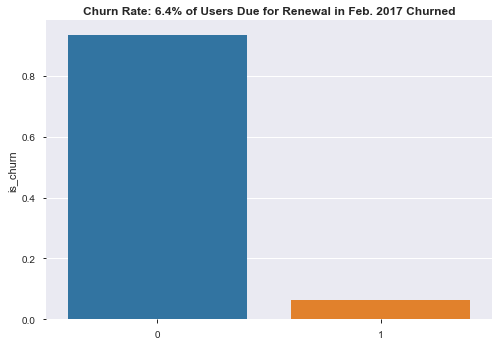

In [411]:
# Look at target variable's distribution:
target = 'is_churn'

sns.barplot(x=train_all[target].value_counts().index, 
            y=train_all[target].value_counts(normalize=True))
plt.title(f"Churn Rate: {train_all[target].value_counts(normalize=True).loc[1] * 100:.1f}% of Users Due for Renewal in Feb. 2017 Churned", fontweight="bold")
plt.show()

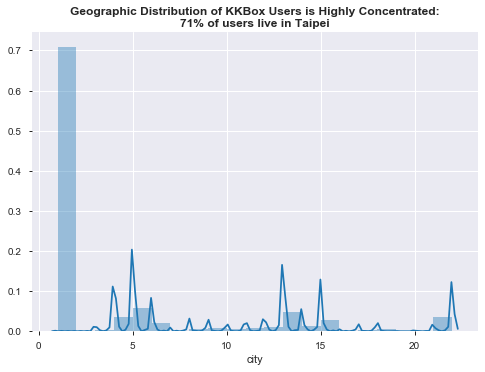

In [412]:
# Members by city: Almost all (70%) live in Taipei:
cities_all = pd.DataFrame(members_all['city'].value_counts(dropna=False))
cities_all['%'] = members_all['city'].value_counts(normalize=True, dropna=False)
cities_all.reset_index(inplace=True)
cities_all.rename(columns={'index': 'city', 'city': 'customers'}, inplace=True)

sns.distplot(members_all['city'], bins=members_all['city'].nunique())
plt.title(f"Geographic Distribution of KKBox Users is Highly Concentrated:\n{cities_all[cities_all['city'] == 1]['%'][0] * 100:.0f}% of users live in Taipei", fontweight="bold")
plt.show()

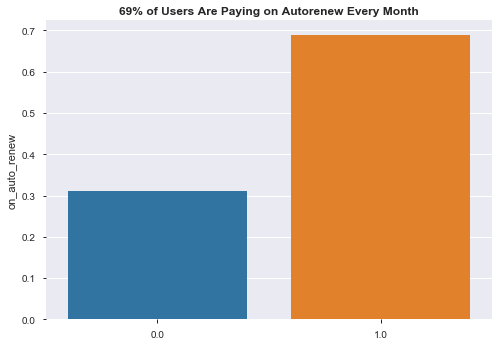

In [413]:
# Autorenew: % of customers who pay on autorenew:
autorenew_dist = train['on_auto_renew'].value_counts(normalize=True)
sns.barplot(x=autorenew_dist.index, 
            y=autorenew_dist);
plt.title(f"{autorenew_dist.loc[1] * 100:.0f}% of Users Are Paying on Autorenew Every Month", fontweight="bold")
plt.show()

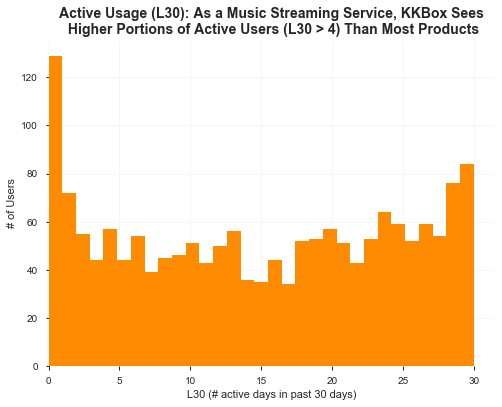

In [541]:
# L30 histogram (L30: an active usage metric that is # days active / last 30 days for each user, bucketed below):
plt.figure(figsize=(8, 6))
plt.style.context('seaborn-notebook')

plt.hist(train['active_days_L30_last_month'], bins=train['active_days_L30_last_month'].nunique(), color='darkorange')

ax = plt.gca()
ax.set(facecolor='white')
ax.grid(True, color='whitesmoke')
ax.set_xlim(0)

# Show or hide borders:
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_visible(True)

plt.title("Active Usage (L30): As a Music Streaming Service, KKBox Sees\n Higher Portions of Active Users (L30 > 4) Than Most Products", fontweight='bold', fontsize=14)
plt.xlabel('L30 (# active days in past 30 days)')
plt.ylabel('# of Users')
plt.show()

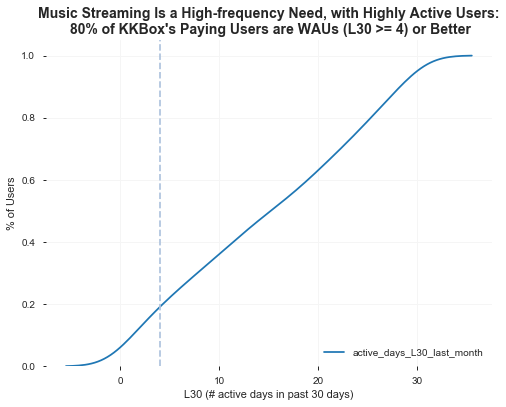

In [527]:
# CDF of # users vs. CDF of # of total active days in L30:
# --> to show us how many of KKBox's users drive (account for) the majority of total active KKBox usage
# L30 histogram (L30: an active usage metric that is # days active / last 30 days for each user, bucketed below):
plt.figure(figsize=(8, 6))
plt.style.context('seaborn-notebook')

sns.kdeplot(train['active_days_L30_last_month'].dropna(), cumulative=True, clip=(0, 30)) #, bins=train['active_days_L30_last_month'].nunique(), color='darkorange')

ax = plt.gca()
ax.set(facecolor='white')
ax.grid(True, color='whitesmoke')
# ax.set_xlim(0, 30)

# Show or hide borders:
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_visible(True)

plt.title("Music Streaming Is a High-frequency Need, with Highly Active Users:\n 80% of KKBox's Paying Users are WAUs (L30 >= 4) or Better", fontweight='bold', fontsize=14)
plt.axvline(x=28/7, linestyle='--', color='lightsteelblue')
plt.xlabel('L30 (# active days in past 30 days)')
plt.ylabel('% of Users')
plt.legend(loc='best')
plt.show()

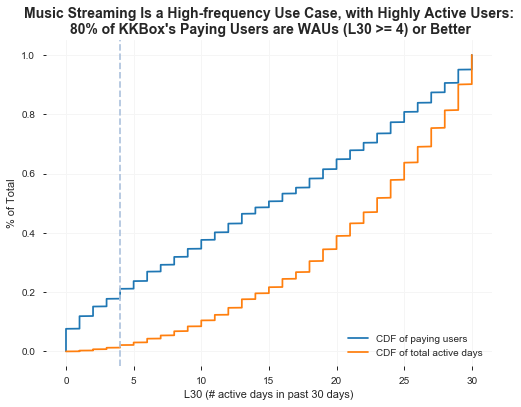

In [529]:
# CDF of # users vs. CDF of # of total active days in L30:
# --> to show us how many of KKBox's users drive (account for) the majority of total active KKBox usage
# L30 histogram (L30: an active usage metric that is # days active / last 30 days for each user, bucketed below):
plt.figure(figsize=(8, 6))
plt.style.context('seaborn-notebook')

L30_cdf_data = pd.DataFrame(train['active_days_L30_last_month'].copy().dropna().sort_values()).reset_index(drop=True)
L30_cdf_data['cumulative_users'] = L30_cdf_data.index + 1
L30_cdf_data['%_of_users'] = L30_cdf_data['cumulative_users'] / len(L30_cdf_data['cumulative_users'])
L30_cdf_data['cumulative_active_days'] = L30_cdf_data['active_days_L30_last_month'].cumsum()
L30_cdf_data['%_of_active_days'] = L30_cdf_data['cumulative_active_days'] / L30_cdf_data['active_days_L30_last_month'].sum()

# Plot the CDFs of L30 (# active days) last month for both # users and # active days:
plt.plot(L30_cdf_data['active_days_L30_last_month'], L30_cdf_data['%_of_users'])
plt.plot(L30_cdf_data['active_days_L30_last_month'], L30_cdf_data['%_of_active_days'])

ax = plt.gca()
ax.set(facecolor='white')
ax.grid(True, color='whitesmoke')

# Show or hide borders:
for spine in ax.spines.values():
    spine.set_color('black')
    spine.set_visible(True)

plt.title("Music Streaming Is a High-frequency Use Case, with Highly Active Users:\n 80% of KKBox's Paying Users are WAUs (L30 >= 4) or Better", fontweight='bold', fontsize=14)
plt.axvline(x=28/7, linestyle='--', color='lightsteelblue')

plt.xlabel('L30 (# active days in past 30 days)')
plt.ylabel('% of Total')
plt.legend(['CDF of paying users', 'CDF of total active days'], loc='best')
plt.show()

### Follow 1 single user for reference [?? To do: remove ??]

In [557]:
single_user_msno = train.sample(n=1, replace=False) # random_state=42
single_user_msno = list(single_user_msno['msno'])

In [558]:
single_user_msno

['TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU=']

In [559]:
train[train['msno'].isin(single_user_msno)]

msno  is_churn  city  age  \
1980  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU=         0   1.0  NaN   

     gender  registered_via registration_init_time  gender_male  gender_nan  \
1980    NaN             7.0             2016-12-23            0           1   

      gender_female  ...  active_days_L30_last_month  \
1980              0  ...                        24.0   

      active_days_L30_last_6_months_avg  is_MAU_last_month  is_WAU_last_month  \
1980                                5.5               True               True   

     is_WAU_last_6_months  is_DAU_last_month is_DAU_last_6_months  \
1980                  NaN               True                  NaN   

      avg_min_per_song last_6_months_avg_monthly_mins  \
1980          2.291544                     435.787736   

      last_month_vs_6_month_avg  
1980                   4.353951  

[1 rows x 46 columns]

In [560]:
members[members['msno'].isin(single_user_msno)]

msno  city  age gender  \
4544456  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU=     1  NaN    NaN   

         registered_via registration_init_time  
4544456             7.0             2016-12-23

In [561]:
transactions[transactions['msno'].isin(single_user_msno)].sort_values(by='transaction_date', ascending=True)

msno  payment_method_id  \
16281046  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU=                 41   
7854863   TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU=                 41   
16848577  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU=                 41   
22389097  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU=                 41   

          payment_plan_days  plan_list_price  actual_amount_paid  \
16281046                 30              149                 149   
7854863                  30              149                 149   
16848577                 30              149                 149   
22389097                 30              149                 149   

          is_auto_renew transaction_date membership_expire_date  is_cancel  \
16281046              1       2016-12-23             2017-01-22          0   
7854863               1       2017-01-22             2017-02-22          0   
16848577              1       2017-02-22             2017-03-22          0   
22389097              1       2017-03-22             2017-04-22          0   

          actual_amount_paid_per_30_days  
16281046                           149.0  
7854863                            149.0  
16848577                           149.0  
22389097                           149.0

In [562]:
user_logs[user_logs['msno'].isin(single_user_msno)].sort_values(by='date', ascending=True)

msno       date  num_25  \
125239169  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU= 2016-12-24      18   
130643282  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU= 2016-12-25       2   
136181229  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU= 2016-12-26      15   
148374284  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU= 2016-12-27      12   
151151807  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU= 2016-12-28       9   
...                                                 ...        ...     ...   
405111064  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU= 2017-03-27       4   
399093003  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU= 2017-03-28      14   
398012346  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU= 2017-03-29       9   
406239034  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU= 2017-03-30      43   
393270351  TBl1IOrrL8phvHGRhtsCzx43fqL71BHAdppnuYAFCOU= 2017-03-31      32   

           num_50  num_75  num_985  num_100  num_unq  total_secs  
125239169       0       3        1       14       29    3760.625  
130643282       0       0        0        4        6     899.679  
136181229       2       1        0       19       32    4979.062  
148374284       1       2        1       40       55    9703.450  
151151807       1       0        1       36       44    8031.648  
...           ...     ...      ...      ...      ...         ...  
405111064       4       1        2        7       15    2748.094  
399093003       9       1        0       39       49    9759.087  
398012346       1       0        3       38       25    9309.627  
406239034       2       1        2       20       62    5310.603  
393270351       3       1        2       24       55    6579.224  

[79 rows x 9 columns]

# **Feature Selection:**

In [563]:
train

msno  is_churn  city   age  \
0     VoC/tkOpx5rSrD5jfelSls8gv24qJ2IwY2+FfK7tK/s=         1  13.0  26.0   
1     poXelk4L2lJRYUudjtpiyKsCWYNWf3gdfHYkXs98ylA=         0   1.0   NaN   
2     RUC5EU2eXOuDYawBez0KcY1tKWe6l0UvzG4F9nDs2AI=         1   4.0  18.0   
3     J1ySpIEtHy5/fHbMOkx69ZWI/XbW2EpGo09f473gDDM=         0   1.0   NaN   
4     7J8I9mhPRDQJvlegKfyEhBrzSll+hrCObf5wPpPI0RQ=         1   5.0  20.0   
...                                            ...       ...   ...   ...   
1995  Rrr/UlncgqTxXD9cpGN1GsCaVjM35AGoIZVq8aIC0Lc=         1   1.0   NaN   
1996  aWOGVPMwjLMux4Ga8+gPcZcAUoEldwZbe163FO237MQ=         1   5.0  20.0   
1997  IEuNtYtW/Fix6BBBMWKxPsK+dkEvYmejtXRNSXOATF8=         0   1.0   NaN   
1998  yOBm+kyVQ2ufe8mTcwJouzRrhWGZRLGaE/m2akEo7kc=         1   4.0   NaN   
1999  Y+rrOcPMTOKhq5nPWhpENx8bjThS663wKrtf0WX+msU=         1   1.0   NaN   

      gender  registered_via registration_init_time  gender_male  gender_nan  \
0       male             4.0             2016-04-09            1           0   
1        NaN             7.0             2016-11-30            0           1   
2       male             3.0             2014-09-06            1           0   
3        NaN             7.0             2012-01-14            0           1   
4       male             9.0             2015-06-16            1           0   
...      ...             ...                    ...          ...         ...   
1995     NaN             7.0             2012-12-26            0           1   
1996  female             4.0             2016-06-03            0           0   
1997     NaN             7.0             2013-10-09            0           1   
1998     NaN             9.0             2015-12-27            0           1   
1999     NaN             4.0             2015-10-24            0           1   

      gender_female  ...  active_days_L30_last_month  \
0                 0  ...                         0.0   
1                 0  ...                        16.0   
2                 0  ...                        28.0   
3                 0  ...                         0.0   
4                 0  ...                        16.0   
...             ...  ...                         ...   
1995              0  ...                        30.0   
1996              1  ...                         6.0   
1997              0  ...                        22.0   
1998              0  ...                        11.0   
1999              0  ...                        29.0   

      active_days_L30_last_6_months_avg  is_MAU_last_month  is_WAU_last_month  \
0                              1.000000              False              False   
1                              6.000000               True               True   
2                             28.833333               True               True   
3                              0.166667              False              False   
4                             17.500000               True               True   
...                                 ...                ...                ...   
1995                           7.000000               True               True   
1996                          14.166667               True               True   
1997                          23.000000               True               True   
1998                          22.333333               True               True   
1999                          11.666667               True               True   

     is_WAU_last_6_months  is_DAU_last_month is_DAU_last_6_months  \
0                   False              False                False   
1                     NaN              False                  NaN   
2                    True               True                False   
3                   False              False                False   
4                   False              False                False   
...                   ...                ...                  ...   
1995                False               Tru

In [564]:
val

msno  is_churn  city   age  \
0     Bu3vaBx1CkanJ9UmbJk70x3qIc1WBkVeOkGGwB+FAVc=         0   1.0   NaN   
1     Zx6c9VSBnj0O8L4SuNXpu/yV5QYo7XSvv1VjSImaF7k=         0   NaN   NaN   
2     j9T1MdUTuRCURN/TPotX1b2Jhd6uGChCF63RbkVToZI=         0   4.0  30.0   
3     KAmIIc7EsTcjkqc16YmKJsdfAoUBN2NzJLSiej5TFt4=         1   1.0   NaN   
4     gp5uBnYOMtyCH0I0OWD+TdSp3cSeD13gJHotGtf1wiY=         0   1.0   NaN   
...                                            ...       ...   ...   ...   
1995  HnUctZ0Fxl0Ss5Yi3bJeAOEBRtqe29HGdLFa/ofcI6I=         0   7.0   NaN   
1996  LesztFi5GIqq8GsJej6LMysE6U0ATkGCaoCATYebzb8=         0   4.0  40.0   
1997  ydpshRYSuy9s+/iHGMKSxfpJSiVki6CoBzgYUw7xE7A=         0   1.0   NaN   
1998  +iPH8IrKAIA16trjeEfja6AAy9yPfqtelSXpgidQwQ8=         1   5.0  34.0   
1999  Aj3EdhErr0e9DG2Nghlqlpb4d9m7u14UYf1Cy8L/wUI=         0   1.0   NaN   

      gender  registered_via registration_init_time  gender_nan  gender_male  \
0        NaN             4.0             2016-04-29           1            0   
1        NaN             NaN                    NaT           1            0   
2       male             9.0             2011-03-07           0            1   
3        NaN             4.0             2016-04-30           1            0   
4        NaN             7.0             2013-02-03           1            0   
...      ...             ...                    ...         ...          ...   
1995     NaN             9.0             2014-08-13           1            0   
1996    male             9.0             2007-03-05           0            1   
1997     NaN             7.0             2013-02-18           1            0   
1998  female             9.0             2014-02-21           0            0   
1999     NaN            13.0             2016-09-07           1            0   

      gender_female  ...  active_days_L30_last_month  \
0                 0  ...                        29.0   
1                 0  ...                         NaN   
2                 0  ...                        23.0   
3                 0  ...                        15.0   
4                 0  ...                         0.0   
...             ...  ...                         ...   
1995              0  ...                        18.0   
1996              0  ...                         1.0   
1997              0  ...                        30.0   
1998              1  ...                         4.0   
1999              0  ...                        29.0   

      active_days_L30_last_6_months_avg  is_MAU_last_month  is_WAU_last_month  \
0                             21.166667               True               True   
1                                   NaN              False              False   
2                             26.333333               True               True   
3                              6.666667               True               True   
4                              3.166667              False              False   
...                                 ...                ...                ...   
1995                          16.666667               True               True   
1996                           1.000000               True              False   
1997                          27.000000               True               True   
1998                           4.166667               True              False   
1999                          22.166667               True               True   

     is_WAU_last_6_months  is_DAU_last_month is_DAU_last_6_months  \
0                   False               True                False   
1                     NaN              False                  NaN   
2                    True               True                False   
3                   False              False                False   
4                   False              False                False   
...                   ...                ...                  ...   
1995                False              Fals

**Final Features Selected:**

In [565]:
# Define final features and target, based on above findings re feature importances:
target = 'is_churn'

features = set(train.columns)
to_remove = set([
                 # Target variable:
                 target, 
                 
                 # Irrelevant information and/or no variance:
                 # [?? To do ??]
                 'msno', 'registration_init_time', 'gender', 
                 
                 # Redundant (near copies of info in other columns):
                 # [?? To do ??]
                 
                 # Very low permutation importances:
                 # [?? To do ??]
                 
                 # Far too many NaNs --> better to drop than impute:
                 # Removed: 'age' has >50% NaNs, but nonetheless helps our models a lot (esp. for TPR/recall), so 
                 # decided to keep despite the NaNs.
                 ])
features = list(features - to_remove)

# Features matrices and target vectors for train and val sets:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
# X_test = test[features]  # [?? To do: Reinstate test here and everywhere above!! ??]

# # Check to make sure X matrices have the same numbers of columns:
# assert X_train.shape[1] == X_val.shape[1] == X_test.shape[1]

In [566]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape
# X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape

((2000, 42), (2000, 42), (2000,), (2000,))

In [567]:
X_train.columns

Index(['age', 'city', 'payment_method_latest', 'churned_full_in_past',
       'active_days_L30_last_6_months_avg', 'num_unique_last_6_months',
       'last_6_months_avg_monthly_mins', 'total_mins_last_month',
       'num_songs_listened_last_6_months', 'is_WAU_last_6_months',
       'avg_min_per_song', 'cost_per_month', 'is_DAU_last_month',
       'last_month_vs_6_month_avg', 'songs_percent_loved_last_6_months',
       'songs_affinity_nps_last_month', 'num_songs_listened_last_month',
       'churn_returned_in_past', 'gender_female', 'on_auto_renew',
       'churned_any_num_times', 'churned_full_num_times',
       'churn_returned_num_times', 'num_songs_started_last_month',
       'gender_male', 'songs_percent_disliked_last_month',
       'total_mins_last_6_months', 'num_songs_finished_last_6_months',
       'is_DAU_last_6_months', 'num_unique_last_month', 'is_MAU_last_month',
       'active_days_L30_last_month', 'total_days_since_joined',
       'songs_percent_disliked_last_6_months', 'n

# **Baselines:**

### Baseline 1:  Dummy Model:  Majority Classifier:

In [568]:
y_train.value_counts(dropna=False, normalize=True)

1    0.5
0    0.5
Name: is_churn, dtype: float64

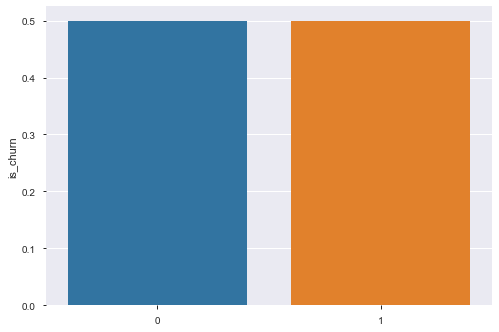

In [569]:
sns.barplot(x=y_train.value_counts(normalize=True).index, 
            y=y_train.value_counts(normalize=True));

In [570]:
majority_class = y_train.mode()[0]

In [571]:
# Get relevant score for our Baseline 1: Majority Classifier dummy model:
y_true_val = y_val
y_pred_b1_val = [majority_class] * len(y_val)

# Get confusion matrix:
cm_b1_val = pd.DataFrame(confusion_matrix(y_true_val, y_pred_b1_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_b1_val.loc['actual_1', 'pred_1']
FN = cm_b1_val.loc['actual_1', 'pred_0']
FP = cm_b1_val.loc['actual_0', 'pred_1']
TN = cm_b1_val.loc['actual_0', 'pred_0']

print('\nBaseline 1:  Majority Classifier Performance:\n')
print(f'Accuracy: {accuracy_score(y_true_val, y_pred_b1_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_val, y_pred_b1_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'False Negative Rate ("Miss Rate"): {FN / (FN + TP):.3f}')
y_pred_b1_val_proba = np.full(shape=(len(y_val), 2), fill_value=[1.0, 0.0])
print(f'Log loss (negative): {log_loss(y_true_val, y_pred_b1_val_proba, eps=10**-15):.3f}')
cm_b1_val


Baseline 1:  Majority Classifier Performance:

Accuracy: 0.941
Recall : 0.000
False Negative Rate ("Miss Rate"): 1.000
Log loss (negative): 2.038


pred_0  pred_1
actual_0    1882       0
actual_1     118       0

In [572]:
# Confusion matrix, normalized:
cm_b1_val / cm_b1_val.sum().sum()

pred_0  pred_1
actual_0   0.941     0.0
actual_1   0.059     0.0

In [573]:
# # Alternate version using sklearn's DummyClassifier class:

# # Get relevant score for our Baseline 1: Majority Classifier dummy model:

# # Import estimator class:
# from sklearn.dummy import DummyClassifier

# # Initialize estimator class:
# b1_dummyclassifier =  DummyClassifier(strategy='most_frequent', random_state=42)

# # Preprocessing:  No need to encode, impute or scale here.

# # Fit model to training data:
# b1_dummyclassifier.fit(X_train, y_train)

# # Apply to val set and get performance metrics:
# y_true_val = y_val
# y_pred_b1_val_dc = b1_dummyclassifier.predict(X_val)


# # Get confusion matrix:
# cm_b1_val_dc = pd.DataFrame(confusion_matrix(y_true_val, y_pred_b1_val_dc), 
#                         index=['actual_0', 'actual_1'], 
#                         columns=['pred_0', 'pred_1'])
# TP = cm_b1_val.loc['actual_1', 'pred_1']
# FN = cm_b1_val.loc['actual_1', 'pred_0']
# FP = cm_b1_val.loc['actual_0', 'pred_1']
# TN = cm_b1_val.loc['actual_0', 'pred_0']

# print('Baseline 1:  Majority Classifier Performance:')
# print(f'Accuracy: {accuracy_score(y_true_val, y_pred_b1_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
# print(f"Recall 2: {recall_score(y_true_val, y_pred_b1_val, average='binary'):.3f}")  # TP / (TP + FN)
# print(f'False Negative Rate ("Miss Rate"): {FN / (FN + TP):.3f}')
# # [?? To do:  Log loss ??]
# print(f'Log loss (negative): {log_loss(y_true_val, b1_dummyclassifier.predict_proba(X_val), eps=10**-15):.3f}')

### Baseline 2:  Simple Single Decision Tree Classifier:

In [574]:
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    DecisionTreeClassifier(min_samples_leaf=2, random_state=42)
)

# Fit on training data:
pipeline.fit(X_train, y_train)

print('\nBaseline #2: Single Decision Tree Classifier: Performance:\n')

# --------- TRAIN --------------------------------------------
# Performance on training data:
y_true_b2_train = y_train
y_pred_b2_train = pipeline.predict(X_train)

# Get TP, FN, FP, TN:
cm_b2_train = pd.DataFrame(confusion_matrix(y_true_b2_train, y_pred_b2_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_b2_train.loc['actual_1', 'pred_1']
FN = cm_b2_train.loc['actual_1', 'pred_0']
FP = cm_b2_train.loc['actual_0', 'pred_1']
TN = cm_b2_train.loc['actual_0', 'pred_0']

print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_b2_train, y_pred_b2_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_b2_train, y_pred_b2_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_b2_train_proba = pipeline.predict_proba(X_train)
print(f'Log loss (negative): {log_loss(y_true_b2_train, y_pred_b2_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_b2_train / cm_b2_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_b2_train / cm_b2_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_b2_val = y_val
y_pred_b2_val = pipeline.predict(X_val)

# Get TP, FN, FP, TN:
cm_b2_val = pd.DataFrame(confusion_matrix(y_true_b2_val, y_pred_b2_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_b2_val.loc['actual_1', 'pred_1']
FN = cm_b2_val.loc['actual_1', 'pred_0']
FP = cm_b2_val.loc['actual_0', 'pred_1']
TN = cm_b2_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_b2_val, y_pred_b2_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_b2_val, y_pred_b2_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_b2_val_proba = pipeline.predict_proba(X_val)
print(f'Log loss (negative): {log_loss(y_true_b2_val, y_pred_b2_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_b2_val / cm_b2_val.sum().sum()).sum().sum(), 10) == 1.0
cm_b2_val / cm_b2_val.sum().sum()

# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]
# print('CROSS-VALIDATED AVG. ACROSS MULTIPLE TRAIN/VAL SPLITS:')
# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]


Baseline #2: Single Decision Tree Classifier: Performance:

TRAINING SET:

Accuracy: 0.935
Recall : 0.897
"Miss Rate" (FNR): 0.103
Log loss (negative): 0.111


VALIDATION SET:

Accuracy: 0.690
Recall : 0.610
"Miss Rate" (FNR): 0.390
Log loss (negative): 9.279

Confusion matrix, normalized:


pred_0  pred_1
actual_0  0.6535  0.2875
actual_1  0.0230  0.0360

In [575]:
# # Plot tree
# # https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html
# import graphviz
# from sklearn.tree import export_graphviz

# b2_dt_estimator = pipeline.named_steps['decisiontreeclassifier']
# encoder = pipeline.named_steps['ordinalencoder']
# encoded_columns = encoder.transform(X_val).columns

# dot_data = export_graphviz(b2_dt_estimator, 
#                            out_file=None, 
#                            max_depth=3, 
#                            feature_names=encoded_columns,
#                            class_names=b2_dt_estimator.classes_, 
#                            impurity=False, 
#                            filled=True, 
#                            proportion=True, 
#                            rounded=True)   
# display(graphviz.Source(dot_data))

In [576]:
# # Feature Importances:
# b2_dt_feat_importances = pd.Series(b2_dt_estimator.feature_importances_, encoded_columns)

# # Plot on chart:
# n = len(encoded_columns)
# plt.figure(figsize=(10, n/2))
# b2_dt_feat_importances.sort_values().plot.barh(color='grey')
# plt.title('Feature Importances: Baseline #2: Single DecisionTree Model')
# plt.show()

# **Models/Predictions:**

### Model 1:  Logistic Regression Classifier w/ Cross-validation:

In [577]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    LogisticRegressionCV(multi_class='ovr', 
                         class_weight='balanced', 
                         cv=StratifiedKFold(n_splits=5), 
                         scoring='neg_log_loss', 
                         solver='lbfgs', 
                         n_jobs=-2, 
                         random_state=42)
)

# Fit on training data:
pipeline.fit(X_train, y_train)


print('\nModel #1: Linear Model: Logistic Regression w/ CV Performance:\n')

# --------- TRAIN --------------------------------------------
# Performance on training data:
y_true_m1_train = y_train
y_pred_m1_train = pipeline.predict(X_train)

# Get TP, FN, FP, TN:
cm_m1_train = pd.DataFrame(confusion_matrix(y_true_m1_train, y_pred_m1_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m1_train.loc['actual_1', 'pred_1']
FN = cm_m1_train.loc['actual_1', 'pred_0']
FP = cm_m1_train.loc['actual_0', 'pred_1']
TN = cm_m1_train.loc['actual_0', 'pred_0']

print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m1_train, y_pred_m1_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m1_train, y_pred_m1_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m1_train_proba = pipeline.predict_proba(X_train)
print(f'Log loss (negative): {log_loss(y_true_m1_train, y_pred_m1_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m1_train / cm_m1_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m1_train / cm_m1_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m1_val = y_val
y_pred_m1_val = pipeline.predict(X_val)

# Get TP, FN, FP, TN:
cm_m1_val = pd.DataFrame(confusion_matrix(y_true_m1_val, y_pred_m1_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m1_val.loc['actual_1', 'pred_1']
FN = cm_m1_val.loc['actual_1', 'pred_0']
FP = cm_m1_val.loc['actual_0', 'pred_1']
TN = cm_m1_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m1_val, y_pred_m1_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m1_val, y_pred_m1_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m1_val_proba = pipeline.predict_proba(X_val)
print(f'Log loss (negative): {log_loss(y_true_m1_val, y_pred_m1_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m1_val / cm_m1_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m1_val / cm_m1_val.sum().sum()

# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]
# print('CROSS-VALIDATED AVG. ACROSS MULTIPLE TRAIN/VAL SPLITS:')
# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]


Model #1: Linear Model: Logistic Regression w/ CV Performance:

TRAINING SET:

Accuracy: 0.756
Recall : 0.639
"Miss Rate" (FNR): 0.361
Log loss (negative): 0.512


VALIDATION SET:

Accuracy: 0.853
Recall : 0.678
"Miss Rate" (FNR): 0.322
Log loss (negative): 0.516

Confusion matrix, normalized:


pred_0  pred_1
actual_0   0.813   0.128
actual_1   0.019   0.040

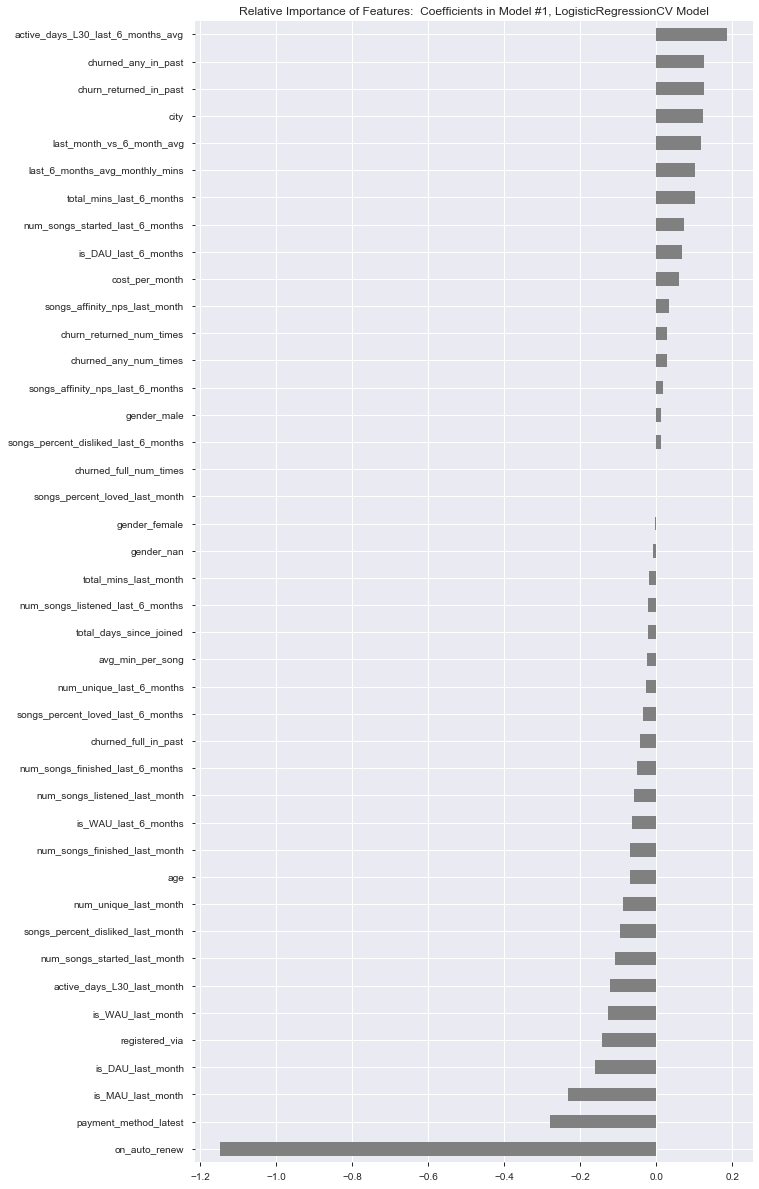

In [578]:
# Feature importances:  Get coefficients of LogisticRegressionCV model to see 
# which features have more of an impact on the model's predictions:
%matplotlib inline
import matplotlib.pyplot as plt

m1_logregcv_coeffs = pipeline.named_steps['logisticregressioncv'].coef_[0]
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
coefficients_table = pd.Series(m1_logregcv_coeffs, encoded_columns)

# Plot on chart:
n = len(encoded_columns)
plt.figure(figsize=(10, n/2))
coefficients_table.sort_values().plot.barh(color='grey')
plt.title('Relative Importance of Features:  Coefficients in Model #1, LogisticRegressionCV Model')
plt.show()

### Model 2: RandomForest Classifier:

In [579]:
from sklearn.ensemble import RandomForestClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, min_samples_leaf=2, n_jobs=-1, random_state=42)
)

# Fit on training data:
pipeline.fit(X_train, y_train)

# Apply to train and get score:
y_true_m2_train = y_train
y_pred_m2_train = pipeline.predict(X_train)

# Get TP, FN, FP, TN:
cm_m2_train = pd.DataFrame(confusion_matrix(y_true_m2_train, y_pred_m2_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m2_train.loc['actual_1', 'pred_1']
FN = cm_m2_train.loc['actual_1', 'pred_0']
FP = cm_m2_train.loc['actual_0', 'pred_1']
TN = cm_m2_train.loc['actual_0', 'pred_0']

print('\nModel #2: RandomForestClassifier Performance:\n')

# --------- TRAIN --------------------------------------------
print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m2_train, y_pred_m2_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m2_train, y_pred_m2_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m2_train_proba = pipeline.predict_proba(X_train)
print(f'Log loss (negative): {log_loss(y_true_m2_train, y_pred_m2_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m2_train / cm_m2_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m2_train / cm_m2_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m2_val = y_val
y_pred_m2_val = pipeline.predict(X_val)

# Get TP, FN, FP, TN:
cm_m2_val = pd.DataFrame(confusion_matrix(y_true_m2_val, y_pred_m2_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m2_val.loc['actual_1', 'pred_1']
FN = cm_m2_val.loc['actual_1', 'pred_0']
FP = cm_m2_val.loc['actual_0', 'pred_1']
TN = cm_m2_val.loc['actual_0', 'pred_0']

print('VALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m2_val, y_pred_m2_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m2_val, y_pred_m2_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m2_val_proba = pipeline.predict_proba(X_val)
print(f'Log loss (negative): {log_loss(y_true_m2_val, y_pred_m2_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m2_val / cm_m2_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m2_val / cm_m2_val.sum().sum()


Model #2: RandomForestClassifier Performance:

TRAINING SET:

Accuracy: 0.953
Recall : 0.943
"Miss Rate" (FNR): 0.057
Log loss (negative): 0.249

VALIDATION SET:

Accuracy: 0.807
Recall : 0.737
"Miss Rate" (FNR): 0.263
Log loss (negative): 0.506

Confusion matrix, normalized:


pred_0  pred_1
actual_0  0.7635  0.1775
actual_1  0.0155  0.0435

**RandomForest w/ Optimized Hyperparameters:**

In [580]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

m2_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

class_weight_1s = train[target].value_counts(normalize=True)[0] / train[target].value_counts(normalize=True)[1]
class_weight_1s_range = [class_weight_1s*0.6, class_weight_1s*0.8, class_weight_1s, class_weight_1s*1.2, class_weight_1s*1.4]

param_distributions_rf = {
    'class_weight': ['balanced', None, {0:1, 1:class_weight_1s_range[0]}, {0:1, 1:class_weight_1s_range[1]}, {0:1, 1:class_weight_1s_range[2]}, {0:1, 1:class_weight_1s_range[3]}, {0:1, 1:class_weight_1s_range[4]}], 
    'max_depth': sp_randint(3, 40), 
    'min_samples_leaf': sp_randint(1, 8), 
    'bootstrap': [True, False], 
    'criterion': ['gini', 'entropy'], 
    'warm_start': [False, True]
}

cv = StratifiedKFold(n_splits=3, random_state=42)

random_search_rf = RandomizedSearchCV(
    m2_rf, 
    param_distributions=param_distributions_rf, 
    n_iter=30, 
    scoring='neg_log_loss',  # Other options: 'recall', 'accuracy', 'roc_auc', 
    # [?? To do: above for scoring=, try to (1) use 'neg_log_loss' (requires predict_proba), (2) use multiple scoring metrics together (there is a way: see line below), (3) see if worthwhile to custom define FNR (miss rate) too ??]
    # multi-metric evaluation, link 1: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
    # multi-metric eval, link 2: https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search
    # Making a custom scoring method (maybe for FNR/miss rate)?:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer
    cv=cv, 
    verbose=True, 
    return_train_score=True, 
    n_jobs=-2, 
    pre_dispatch=2*3, 
    random_state=42
)

random_search_rf.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed:   15.2s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_...
                                                         {0: 1, 1: 1.0},
 

In [581]:
random_search_rf.best_params_

{'bootstrap': False,
 'class_weight': {0: 1, 1: 1.0},
 'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 6,
 'warm_start': False}

In [582]:
pd.DataFrame(random_search_rf.cv_results_).sort_values(by='mean_test_score').T

5   \
mean_fit_time                                                    0.474758   
std_fit_time                                                    0.0497471   
mean_score_time                                                  0.106747   
std_score_time                                                 0.00126601   
param_bootstrap                                                     False   
param_class_weight                                         {0: 1, 1: 1.0}   
param_criterion                                                   entropy   
param_max_depth                                                        27   
param_min_samples_leaf                                                  1   
param_warm_start                                                    False   
params                  {'bootstrap': False, 'class_weight': {0: 1, 1:...   
split0_test_score                                               -0.609811   
split1_test_score                                               -0.643099   
split2_test_score                                               -0.543728   
mean_test_score                                                  -0.59889   
std_test_score                                                  0.0412788   
rank_test_score                                                        30   
split0_train_score                                             -0.0505627   
split1_train_score                                             -0.0526459   
split2_train_score                                             -0.0571131   
mean_train_score                                               -0.0534406   
std_train_score                                                0.00273257   

                                                                       17  \
mean_fit_time                                                    0.455348   
std_fit_time                                                    0.0493486   
mean_score_time                                                  0.108019   
std_score_time                                                  0.0013035   
param_bootstrap                                                      True   
param_class_weight                                         {0: 1, 1: 1.0}   
param_criterion                                                   entropy   
param_max_depth                                                        28   
param_min_samples_leaf                                                  1   
param_warm_start                                                     True   
params                  {'bootstrap': True, 'class_weight': {0: 1, 1: ...   
split0_test_score                                                -0.67275   
split1_test_score                                               -0.541443   
split2_test_score                                               -0.529557   
mean_test_score                                                 -0.581341   
std_test_score                                                  0.0649141   
rank_test_score                                                        29   
split0_train_score                                               -0.18182   
split1_train_score                                              -0.178081   
split2_train_score                                              -0.182623   
mean_train_score                                                -0.180841   
std_train_score                                                  0.001979   

                                                                       11  \
mean_fit_time                                                    0.406189   
std_fit_time                                                     0.020142   
mean_score_time                                                   0.12552   
std_score_time                                                 0.00726808   
param_bootstrap                                                     False   
param_class_weight                                         {0: 1,

In [583]:
print('\nModel #2: RandomForestClassifier w/ Optimized Hyperparameters:\n')

# --------- TRAIN --------------------------------------------
# Apply to train and get score:
y_true_m2_train = y_train
y_pred_m2_train = random_search_rf.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_m2_train = pd.DataFrame(confusion_matrix(y_true_m2_train, y_pred_m2_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m2_train.loc['actual_1', 'pred_1']
FN = cm_m2_train.loc['actual_1', 'pred_0']
FP = cm_m2_train.loc['actual_0', 'pred_1']
TN = cm_m2_train.loc['actual_0', 'pred_0']

print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m2_train, y_pred_m2_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m2_train, y_pred_m2_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m2_train_proba = random_search_rf.predict_proba(X_train_transformed)
print(f'Log loss (negative): {log_loss(y_true_m2_train, y_pred_m2_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m2_train / cm_m2_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m2_train / cm_m2_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m2_val = y_val
y_pred_m2_val = random_search_rf.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_m2_val = pd.DataFrame(confusion_matrix(y_true_m2_val, y_pred_m2_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m2_val.loc['actual_1', 'pred_1']
FN = cm_m2_val.loc['actual_1', 'pred_0']
FP = cm_m2_val.loc['actual_0', 'pred_1']
TN = cm_m2_val.loc['actual_0', 'pred_0']

print('VALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m2_val, y_pred_m2_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m2_val, y_pred_m2_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m2_val_proba = random_search_rf.predict_proba(X_val_transformed)
print(f'Log loss (negative): {log_loss(y_true_m2_val, y_pred_m2_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m2_val / cm_m2_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m2_val / cm_m2_val.sum().sum()


Model #2: RandomForestClassifier w/ Optimized Hyperparameters:

TRAINING SET:

Accuracy: 0.797
Recall : 0.679
"Miss Rate" (FNR): 0.321
Log loss (negative): 0.454

VALIDATION SET:

Accuracy: 0.850
Recall : 0.686
"Miss Rate" (FNR): 0.314
Log loss (negative): 0.509

Confusion matrix, normalized:


pred_0  pred_1
actual_0  0.8090  0.1320
actual_1  0.0185  0.0405

In [584]:
random_search_rf.best_estimator_

RandomForestClassifier(bootstrap=False, class_weight={0: 1, 1: 1.0},
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [585]:
# Estimator with best hyperparameters:
m2_rf = random_search_rf.best_estimator_

m2_rf.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=False, class_weight={0: 1, 1: 1.0},
                       criterion='entropy', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

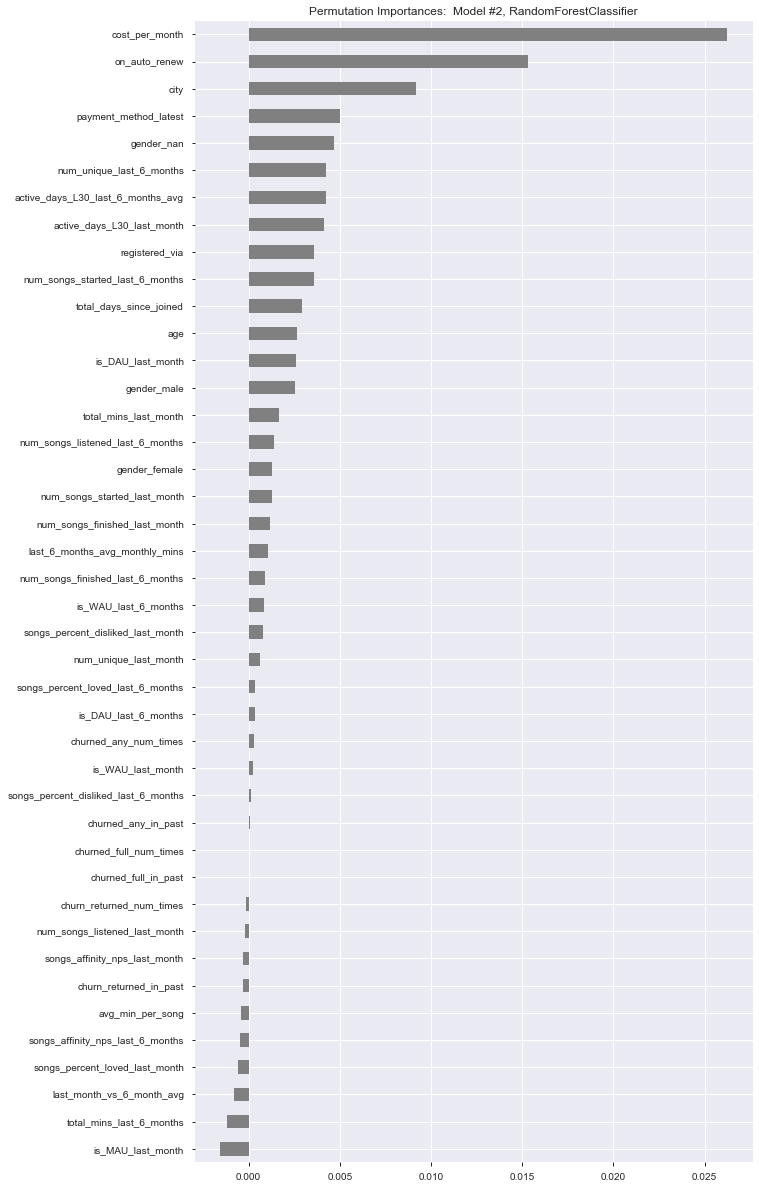

In [586]:
# Permutation importances:

# Initialize and fit the permuter:
import eli5
from eli5.sklearn import PermutationImportance

permuter_rf = PermutationImportance(
    m2_rf, 
    scoring='neg_log_loss',  # Other options: 'neg_log_loss', 'recall', 'accuracy', ROC AUC ??
    n_iter=5, 
    random_state=42
)

permuter_rf.fit(X_val_transformed, y_val)

# -----------------------------------------------------------------------------------------------------------

# Plot chart with the permutation importance values for each feature:
%matplotlib inline
import matplotlib.pyplot as plt

feature_names = X_val.columns.tolist()
perm_importances_rf = pd.Series(permuter_rf.feature_importances_, feature_names)

# Plot feature importances:
n = len(feature_names)
plt.figure(figsize=(10, n/2))
perm_importances_rf.sort_values(ascending=True).plot.barh(color='grey')
plt.title('Permutation Importances:  Model #2, RandomForestClassifier')
plt.show()

In [587]:
# Show heatmap w/ permutation importances' weights:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter_rf, 
    top=None, 
    feature_names=feature_names
)

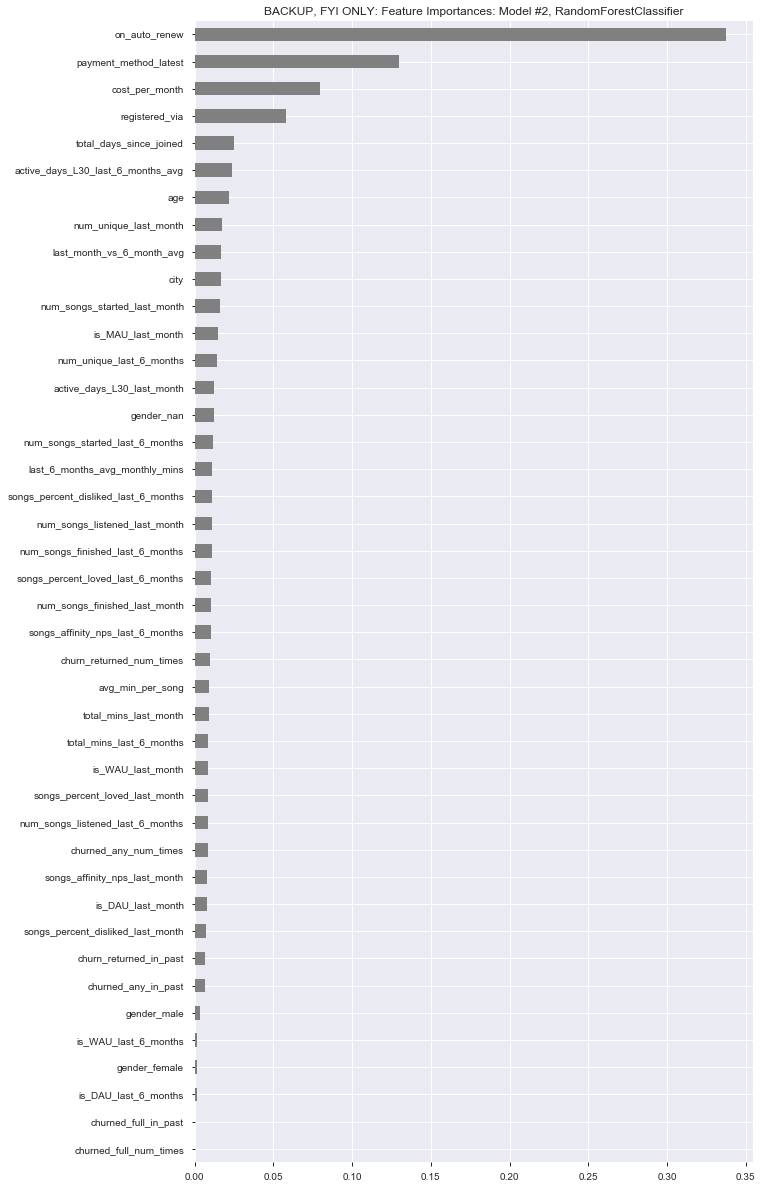

In [588]:
# BACKUP, FYI ONLY: Raw feature importances from model:

# Feature importances:
%matplotlib inline
import matplotlib.pyplot as plt

encoder = transformers.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_train).columns
feat_importances_rf = pd.Series(m2_rf.feature_importances_, encoded_columns)

# Plot feature importances:
n = len(encoded_columns)
plt.figure(figsize=(10, n/2))
feat_importances_rf.sort_values().plot.barh(color='grey')
plt.title('BACKUP, FYI ONLY: Feature Importances: Model #2, RandomForestClassifier')
plt.show()

### Model 3:  Gradient-boosted Trees (Ensemble)

In [589]:
from xgboost import XGBClassifier

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

m3_gbt = XGBClassifier(n_estimators=50, max_depth=8, n_jobs=-1, random_state=42)
m3_gbt.fit(X_train_transformed, y_train)

# Performance on training data:
y_true_m3_train = y_train
y_pred_m3_train = m3_gbt.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_m3_train = pd.DataFrame(confusion_matrix(y_true_m3_train, y_pred_m3_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_train.loc['actual_1', 'pred_1']
FN = cm_m3_train.loc['actual_1', 'pred_0']
FP = cm_m3_train.loc['actual_0', 'pred_1']
TN = cm_m3_train.loc['actual_0', 'pred_0']

print('\nModel #3: Gradient-boosted Trees Performance:\n')

# --------- TRAIN --------------------------------------------
print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_train, y_pred_m3_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_train, y_pred_m3_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_train_proba = m3_gbt.predict_proba(X_train_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_train, y_pred_m3_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m3_train / cm_m3_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m3_train / cm_m3_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m3_val = y_val
y_pred_m3_val = m3_gbt.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_m3_val = pd.DataFrame(confusion_matrix(y_true_m3_val, y_pred_m3_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_val.loc['actual_1', 'pred_1']
FN = cm_m3_val.loc['actual_1', 'pred_0']
FP = cm_m3_val.loc['actual_0', 'pred_1']
TN = cm_m3_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_val, y_pred_m3_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_val, y_pred_m3_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_val_proba = m3_gbt.predict_proba(X_val_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_val, y_pred_m3_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m3_val / cm_m3_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m3_val / cm_m3_val.sum().sum()


Model #3: Gradient-boosted Trees Performance:

TRAINING SET:

Accuracy: 0.934
Recall : 0.904
"Miss Rate" (FNR): 0.096
Log loss (negative): 0.243


VALIDATION SET:

Accuracy: 0.802
Recall : 0.695
"Miss Rate" (FNR): 0.305
Log loss (negative): 0.517

Confusion matrix, normalized:


pred_0  pred_1
actual_0  0.7615  0.1795
actual_1  0.0180  0.0410

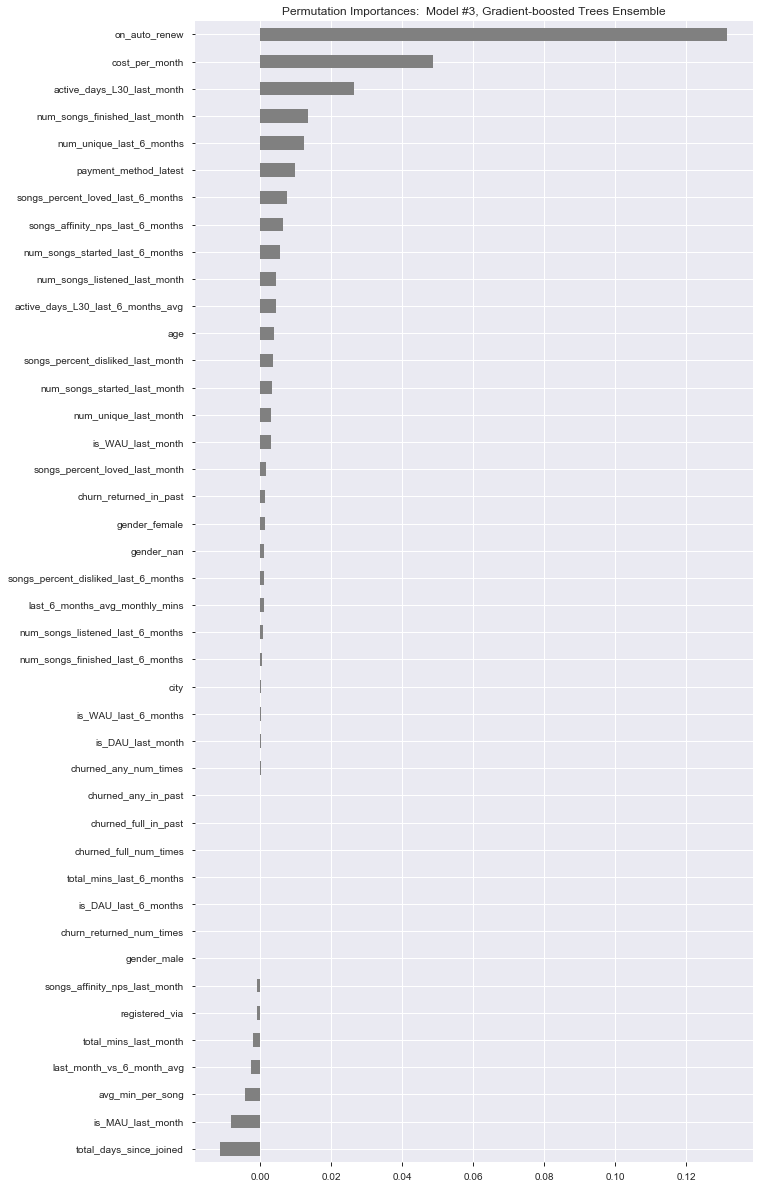

In [590]:
# Initialize and fit the permuter:
import eli5
from eli5.sklearn import PermutationImportance

permuter_gbt = PermutationImportance(
    m3_gbt, 
    scoring='neg_log_loss',  # OR 'neg_log_loss'
    n_iter=5, 
    random_state=42
)

permuter_gbt.fit(X_val_transformed, y_val)

# -----------------------------------------------------------------------------------------------------------

# Plot chart with the permutation importance values for each feature:
%matplotlib inline
import matplotlib.pyplot as plt

feature_names = X_val.columns.tolist()
perm_importances_gbt = pd.Series(permuter_gbt.feature_importances_, feature_names)

# Plot feature importances:
n = len(feature_names)
plt.figure(figsize=(10, n/2))
perm_importances_gbt.sort_values(ascending=True).plot.barh(color='grey')
plt.title('Permutation Importances:  Model #3, Gradient-boosted Trees Ensemble')
plt.show()

In [591]:
# Show heatmap w/ permutation importances' weights:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter_gbt, 
    top=None, 
    feature_names=feature_names
)

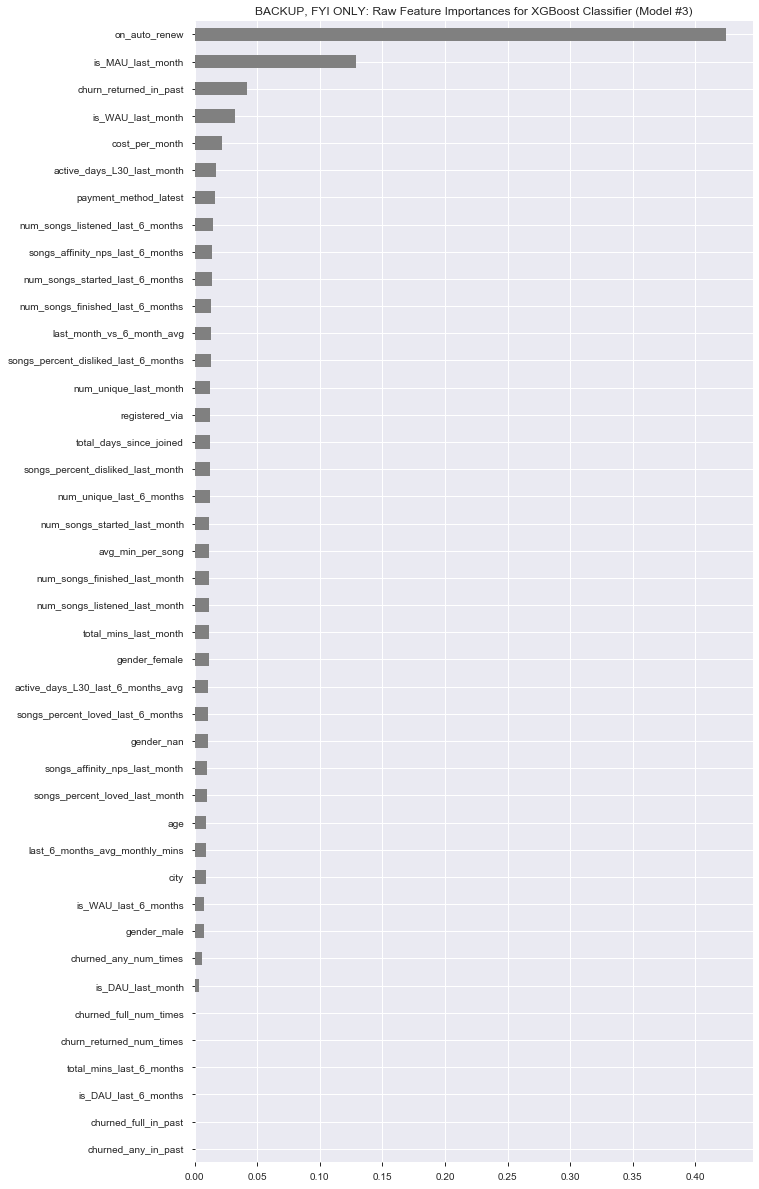

In [592]:
# BACKUP / FYI ONLY:

# Feature importances:
%matplotlib inline
import matplotlib.pyplot as plt

encoder = transformers.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
feat_importances_gbt = pd.Series(m3_gbt.feature_importances_, encoded_columns)

# Plot on chart, sorted from most to least important:
n = len(encoded_columns)
plt.figure(figsize=(10, n/2))
feat_importances_gbt.sort_values().plot.barh(color='grey')
plt.title('BACKUP, FYI ONLY: Raw Feature Importances for XGBoost Classifier (Model #3)')
plt.show()

### Hyperparameter optimization:

In [593]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

m3_gbt = XGBClassifier(n_estimators=50, random_state=42)

scale_pos_weight = train[target].value_counts(normalize=True)[0] / train[target].value_counts(normalize=True)[1]

param_distributions_gbt = {
    'XGBClassifier__max_depth': sp_randint(3, 40), 
    'XGBClassifier__learning_rate': sp_uniform(0, 0.50), 
    'XGBClassifier__min_child_weight': sp_uniform(1, 8), 
    'XGBClassifier__scale_pos_weight': sp_uniform(scale_pos_weight * 0.5, scale_pos_weight * 1.5)
}

cv = StratifiedKFold(n_splits=3, random_state=42)

random_search_gbt = RandomizedSearchCV(
    m3_gbt, 
    param_distributions=param_distributions_gbt, 
    n_iter=30, 
    scoring='neg_log_loss',  # Best options: 'recall', 'neg_log_loss', 'accuracy', 'roc_auc', 
    # [?? To do: above for scoring=, try to (1) use 'neg_log_loss' (requires predict_proba), (2) use multiple scoring metrics together (there is a way: see line below), (3) see if worthwhile to custom define FNR (miss rate) too ??]
    # multi-metric evaluation, link 1: https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html#sphx-glr-auto-examples-model-selection-plot-multi-metric-evaluation-py
    # multi-metric eval, link 2: https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search
    # Making a custom scoring method (maybe for FNR/miss rate)?:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html#sklearn.metrics.make_scorer
    cv=cv, 
    verbose=True, 
    return_train_score=True, 
    n_jobs=-2, 
    pre_dispatch=2*3, 
    random_state=42
)

random_search_gbt.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done  44 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-2)]: Done  90 out of  90 | elapsed:    9.5s finished


RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=False),
                   error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=50,
                                           n_jobs=1, nthread=None...
                                        'XGBClassifier__max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1c6346c88>,
                                        'XGBClassifier__min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x196f229b0>,
         

In [594]:
random_search_gbt.best_params_

{'XGBClassifier__learning_rate': 0.18727005942368125,
 'XGBClassifier__max_depth': 31,
 'XGBClassifier__min_child_weight': 2.4674783189293104,
 'XGBClassifier__scale_pos_weight': 1.669536500409154}

In [595]:
25000 / train_all.shape[0]

0.03357065548719078

In [596]:
random_search_gbt.best_score_

-0.5083042895710096

In [597]:
random_search_gbt.best_estimator_

XGBClassifier(XGBClassifier__learning_rate=0.18727005942368125,
              XGBClassifier__max_depth=31,
              XGBClassifier__min_child_weight=2.4674783189293104,
              XGBClassifier__scale_pos_weight=1.669536500409154, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [598]:
pd.DataFrame(random_search_gbt.cv_results_).sort_values(by='mean_test_score').T

0   \
mean_fit_time                                                                   0.253406   
std_fit_time                                                                  0.00488021   
mean_score_time                                                               0.00695467   
std_score_time                                                                0.00147834   
param_XGBClassifier__learning_rate                                               0.18727   
param_XGBClassifier__max_depth                                                        31   
param_XGBClassifier__min_child_weight                                            2.46748   
param_XGBClassifier__scale_pos_weight                                            1.66954   
params                                 {'XGBClassifier__learning_rate': 0.18727005942...   
split0_test_score                                                              -0.491898   
split1_test_score                                                               -0.52674   
split2_test_score                                                              -0.506323   
mean_test_score                                                                -0.508304   
std_test_score                                                                 0.0142964   
rank_test_score                                                                        1   
split0_train_score                                                             -0.434101   
split1_train_score                                                             -0.413588   
split2_train_score                                                             -0.439352   
mean_train_score                                                               -0.429014   
std_train_score                                                                0.0111165   

                                                                                      27  \
mean_fit_time                                                                   0.228117   
std_fit_time                                                                   0.0134527   
mean_score_time                                                               0.00303205   
std_score_time                                                               0.000287139   
param_XGBClassifier__learning_rate                                              0.302209   
param_XGBClassifier__max_depth                                                        17   
param_XGBClassifier__min_child_weight                                            7.04441   
param_XGBClassifier__scale_pos_weight                                           0.843197   
params                                 {'XGBClassifier__learning_rate': 0.30220868963...   
split0_test_score                                                              -0.491898   
split1_test_score                                                               -0.52674   
split2_test_score                                                              -0.506323   
mean_test_score                                                                -0.508304   
std_test_score                                                                 0.0142964   
rank_test_score                                                                        1   
split0_train_score                                                             -0.434101   
split1_train_score                                                             -0.413588   
split2_train_score                                                             -0.439352   
mean_train_score                                                               -0.429014   
std_train_score                                                                0.0111165   

                                                                                      26  \
mean_fit_time                                                                   0.227546   
std_fit_time                        

In [599]:
print('\nModel #3(b) Performance: Gradient-boosted Trees w/ Best Hyperparameters:\n')

# --------- TRAIN --------------------------------------------
# Performance on training data:
y_true_m3_train = y_train
y_pred_m3_train = random_search_gbt.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_m3_train = pd.DataFrame(confusion_matrix(y_true_m3_train, y_pred_m3_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_train.loc['actual_1', 'pred_1']
FN = cm_m3_train.loc['actual_1', 'pred_0']
FP = cm_m3_train.loc['actual_0', 'pred_1']
TN = cm_m3_train.loc['actual_0', 'pred_0']

print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_train, y_pred_m3_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_train, y_pred_m3_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_train_proba = random_search_gbt.predict_proba(X_train_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_train, y_pred_m3_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m3_train / cm_m3_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m3_train / cm_m3_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_m3_val = y_val
y_pred_m3_val = random_search_gbt.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_m3_val = pd.DataFrame(confusion_matrix(y_true_m3_val, y_pred_m3_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_val.loc['actual_1', 'pred_1']
FN = cm_m3_val.loc['actual_1', 'pred_0']
FP = cm_m3_val.loc['actual_0', 'pred_1']
TN = cm_m3_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_val, y_pred_m3_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_val, y_pred_m3_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_val_proba = random_search_gbt.predict_proba(X_val_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_val, y_pred_m3_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m3_val / cm_m3_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m3_val / cm_m3_val.sum().sum()


Model #3(b) Performance: Gradient-boosted Trees w/ Best Hyperparameters:

TRAINING SET:

Accuracy: 0.799
Recall : 0.717
"Miss Rate" (FNR): 0.283
Log loss (negative): 0.448


VALIDATION SET:

Accuracy: 0.827
Recall : 0.720
"Miss Rate" (FNR): 0.280
Log loss (negative): 0.499

Confusion matrix, normalized:


pred_0  pred_1
actual_0  0.7840  0.1570
actual_1  0.0165  0.0425

### Early stopping (for n_estimators):

In [600]:
# Best params to input:
max_depth_best = random_search_gbt.best_params_['XGBClassifier__max_depth']
learning_rate_best = random_search_gbt.best_params_['XGBClassifier__learning_rate']
min_child_weight_best = random_search_gbt.best_params_['XGBClassifier__min_child_weight']

In [601]:
random_search_gbt.best_estimator_

XGBClassifier(XGBClassifier__learning_rate=0.18727005942368125,
              XGBClassifier__max_depth=31,
              XGBClassifier__min_child_weight=2.4674783189293104,
              XGBClassifier__scale_pos_weight=1.669536500409154, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
              n_jobs=1, nthread=None, objective='binary:logistic',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=1, verbosity=1)

In [602]:
from xgboost import XGBClassifier

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

m3_gbt_tuned = XGBClassifier(n_estimators=1000, 
                             max_depth=max_depth_best, 
                             learning_rate=learning_rate_best, 
                             min_child_weight=min_child_weight_best, 
                             n_jobs=-2, 
                             random_state=42)

eval_set = [(X_train_transformed, y_train), 
           (X_val_transformed, y_val)]

m3_gbt_tuned.fit(X_train_transformed, 
           y_train, 
           eval_set=eval_set, 
           eval_metric='logloss',  # Options: logloss, (no recall...), auc (https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters)
           verbose=True, 
           early_stopping_rounds=50)

# Performance on training data:
y_true_m3_train = y_train
y_pred_m3_train = m3_gbt_tuned.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_m3_train = pd.DataFrame(confusion_matrix(y_true_m3_train, y_pred_m3_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_train.loc['actual_1', 'pred_1']
FN = cm_m3_train.loc['actual_1', 'pred_0']
FP = cm_m3_train.loc['actual_0', 'pred_1']
TN = cm_m3_train.loc['actual_0', 'pred_0']

print('\nModel #3: Gradient-boosted Trees Performance:\n')

# --------- TRAIN --------------------------------------------
print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_train, y_pred_m3_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_train, y_pred_m3_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_train_proba = m3_gbt_tuned.predict_proba(X_train_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_train, y_pred_m3_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_m3_train / cm_m3_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_m3_train / cm_m3_train.sum().sum()

# ---------- VAL ---------------------------------------------

# Apply to val and get score:
y_true_m3_val = y_val
y_pred_m3_val = m3_gbt_tuned.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_m3_val = pd.DataFrame(confusion_matrix(y_true_m3_val, y_pred_m3_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_m3_val.loc['actual_1', 'pred_1']
FN = cm_m3_val.loc['actual_1', 'pred_0']
FP = cm_m3_val.loc['actual_0', 'pred_1']
TN = cm_m3_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_m3_val, y_pred_m3_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_m3_val, y_pred_m3_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_m3_val_proba = m3_gbt_tuned.predict_proba(X_val_transformed)
print(f'Log loss (negative): {log_loss(y_true_m3_val, y_pred_m3_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_m3_val / cm_m3_val.sum().sum()).sum().sum(), 10) == 1.0
cm_m3_val / cm_m3_val.sum().sum()

[0]	validation_0-logloss:0.612729	validation_1-logloss:0.641864
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.554516	validation_1-logloss:0.601451
[2]	validation_0-logloss:0.507254	validation_1-logloss:0.576399
[3]	validation_0-logloss:0.470792	validation_1-logloss:0.559439
[4]	validation_0-logloss:0.437555	validation_1-logloss:0.546134
[5]	validation_0-logloss:0.408985	validation_1-logloss:0.534077
[6]	validation_0-logloss:0.384548	validation_1-logloss:0.523457
[7]	validation_0-logloss:0.362472	validation_1-logloss:0.517479
[8]	validation_0-logloss:0.344667	validation_1-logloss:0.510534
[9]	validation_0-logloss:0.327612	validation_1-logloss:0.505333
[10]	validation_0-logloss:0.312485	validation_1-logloss:0.502141
[11]	validation_0-logloss:0.298832	validation_1-logloss:0.499778
[12]	validation_0-logloss:0.286867	validation_1-logloss:0.4966
[1

pred_0  pred_1
actual_0  0.7500  0.1910
actual_1  0.0165  0.0425

In [603]:
m3_gbt_tuned.best_score

0.4966

In [604]:
m3_gbt_tuned

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.18727005942368125, max_delta_step=0, max_depth=31,
              min_child_weight=2.4674783189293104, missing=None,
              n_estimators=1000, n_jobs=-2, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [605]:
m3_gbt_tuned.best_iteration

12

In [606]:
m3_gbt_tuned.best_ntree_limit

13

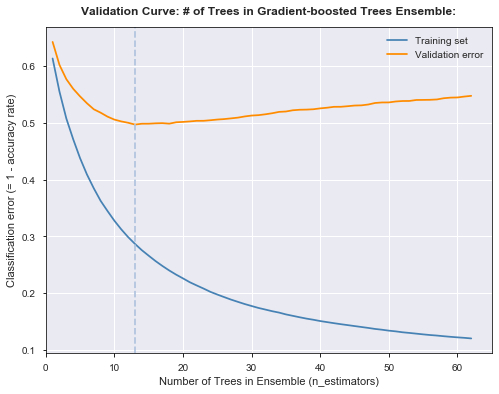

In [607]:
# Validation curve of early stopping results from above:
early_stopping_results = m3_gbt_tuned.evals_result()
train_error = early_stopping_results['validation_0']['logloss']
val_error = early_stopping_results['validation_1']['logloss']

best_num_estimators = m3_gbt_tuned.best_ntree_limit

# Plot these results as a validation curve:

# x-values: Epoch #:
epoch_num = list(range(1, len(train_error) + 1))

# Plot train and val errors:

plt.figure(figsize=(8, 6))
plt.style.context('seaborn-notebook')
plt.plot(epoch_num, train_error, label='Training set', color='steelblue')
plt.plot(epoch_num, val_error, label='Validation error', color='darkorange')

plt.title('Validation Curve: # of Trees in Gradient-boosted Trees Ensemble:', 
          y=1.02, 
          fontsize=12, 
          fontweight='bold')
plt.xlabel('Number of Trees in Ensemble (n_estimators)')
plt.ylabel('Classification error (= 1 - accuracy rate)')
plt.legend()

ax = plt.gca()
# ax.set(facecolor='white')
# ax.grid(True, color='whitesmoke')
ax.set_xlim(0)

# Show or hide borders:
# ax.spines['left'].set_linewidth(0.75)
# ax.spines['left'].set_visible(True)
# ax.spines['left'].set_color('black')

# ax.spines['bottom'].set_linewidth(0.75)
# ax.spines['bottom'].set_visible(True)
# ax.spines['bottom'].set_color('black')

for spine in ax.spines.values():
    spine.set_linewidth(0.75)
    spine.set_color('black')
    spine.set_visible(True)

# Line showing selected best number of trees (n_estimators) to use:
ax.axvline(x=best_num_estimators, linestyle='--', color='lightsteelblue')

plt.show()

# Final Model:

In [608]:
# Best params to input:
assert max_depth_best == random_search_gbt.best_params_['XGBClassifier__max_depth']
assert learning_rate_best == random_search_gbt.best_params_['XGBClassifier__learning_rate']
assert min_child_weight_best == random_search_gbt.best_params_['XGBClassifier__min_child_weight']
assert best_num_estimators == m3_gbt_tuned.best_ntree_limit

In [609]:
from xgboost import XGBClassifier

# Separate transformers/pipeline from XGBClassifier model, so we can later use eli5 to get permutation importances:
transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean')  # Impute NaNs for permuter (next cell), even though not needed for XGBClassifier
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

mfinal = XGBClassifier(n_estimators=best_num_estimators, 
                       max_depth=max_depth_best, 
                       learning_rate=learning_rate_best, 
                       min_child_weight=min_child_weight_best, 
                       n_jobs=-2, 
                       random_state=42)

# mfinal = m3_gbt_tuned

mfinal.fit(X_train_transformed, y_train)

# Performance on training data:
y_true_mfinal_train = y_train
y_pred_mfinal_train = mfinal.predict(X_train_transformed)

# Get TP, FN, FP, TN:
cm_mfinal_train = pd.DataFrame(confusion_matrix(y_true_mfinal_train, y_pred_mfinal_train), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_mfinal_train.loc['actual_1', 'pred_1']
FN = cm_mfinal_train.loc['actual_1', 'pred_0']
FP = cm_mfinal_train.loc['actual_0', 'pred_1']
TN = cm_mfinal_train.loc['actual_0', 'pred_0']

print('\nFinal Model: Gradient-boosted Trees w/ Optimized Hyperparameters:\n')

# --------- TRAIN --------------------------------------------
print('TRAINING SET:\n')
print(f'Accuracy: {accuracy_score(y_true_mfinal_train, y_pred_mfinal_train):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_mfinal_train, y_pred_mfinal_train, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_mfinal_train_proba = mfinal.predict_proba(X_train_transformed)
print(f'Log loss (negative): {log_loss(y_true_mfinal_train, y_pred_mfinal_train_proba, eps=10**-15):.3f}\n')

# print('Confusion matrix, normalized:')
# assert round((cm_mfinal_train / cm_mfinal_train.sum().sum()).sum().sum(), 10) == 1.0
# cm_mfinal_train / cm_mfinal_train.sum().sum()

# ---------- VAL ---------------------------------------------
# Apply to val and get score:
y_true_mfinal_val = y_val
y_pred_mfinal_val = mfinal.predict(X_val_transformed)

# Get TP, FN, FP, TN:
cm_mfinal_val = pd.DataFrame(confusion_matrix(y_true_mfinal_val, y_pred_mfinal_val), 
                        index=['actual_0', 'actual_1'], 
                        columns=['pred_0', 'pred_1'])
TP = cm_mfinal_val.loc['actual_1', 'pred_1']
FN = cm_mfinal_val.loc['actual_1', 'pred_0']
FP = cm_mfinal_val.loc['actual_0', 'pred_1']
TN = cm_mfinal_val.loc['actual_0', 'pred_0']

print('\nVALIDATION SET:\n')
print(f'Accuracy: {accuracy_score(y_true_mfinal_val, y_pred_mfinal_val):.3f}')  # (TP + TN) / (TP + FN + FP + TN)
print(f"Recall : {recall_score(y_true_mfinal_val, y_pred_mfinal_val, average='binary'):.3f}")  # TP / (TP + FN)
print(f'"Miss Rate" (FNR): {FN / (FN + TP):.3f}')
y_pred_mfinal_val_proba = mfinal.predict_proba(X_val_transformed)
print(f'Log loss (negative): {log_loss(y_true_mfinal_val, y_pred_mfinal_val_proba, eps=10**-15):.3f}\n')

print('Confusion matrix, normalized:')
assert round((cm_mfinal_val / cm_mfinal_val.sum().sum()).sum().sum(), 10) == 1.0
cm_mfinal_val / cm_mfinal_val.sum().sum()

# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]
# print('CROSS-VALIDATED AVG. ACROSS MULTIPLE TRAIN/VAL SPLITS:')
# [?? To do:  Add in cross-validation avg. score using cross_val_score ??]


Final Model: Gradient-boosted Trees w/ Optimized Hyperparameters:

TRAINING SET:

Accuracy: 0.924
Recall : 0.912
"Miss Rate" (FNR): 0.088
Log loss (negative): 0.287


VALIDATION SET:

Accuracy: 0.792
Recall : 0.720
"Miss Rate" (FNR): 0.280
Log loss (negative): 0.497

Confusion matrix, normalized:


pred_0  pred_1
actual_0  0.7500  0.1910
actual_1  0.0165  0.0425

In [610]:
mfinal

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.18727005942368125, max_delta_step=0, max_depth=31,
              min_child_weight=2.4674783189293104, missing=None,
              n_estimators=13, n_jobs=-2, nthread=None,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

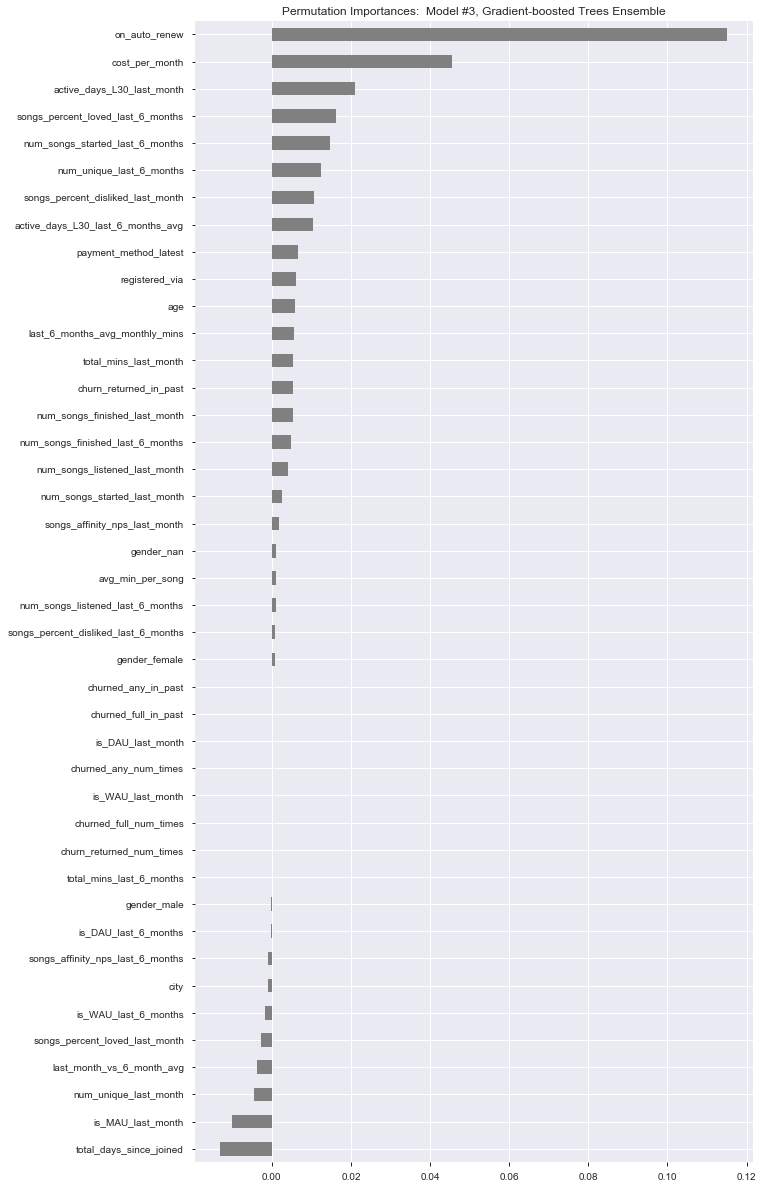

In [611]:
# Initialize and fit the permuter:
import eli5
from eli5.sklearn import PermutationImportance

permuter_mfinal = PermutationImportance(
    mfinal, 
    scoring='neg_log_loss',  # [?? To do: Change scoring in all permuters to -- what, negative log loss ??]
    n_iter=10, 
    random_state=42
)

permuter_mfinal.fit(X_val_transformed, y_val)

# -----------------------------------------------------------------------------------------------------------

# Plot chart with the permutation importance values for each feature:
%matplotlib inline
import matplotlib.pyplot as plt

feature_names = X_val.columns.tolist()
perm_importances_mfinal = pd.Series(permuter_mfinal.feature_importances_, feature_names)

# Plot feature importances:
n = len(feature_names)
plt.figure(figsize=(10, n/2))
perm_importances_mfinal.sort_values(ascending=True).plot.barh(color='grey')
plt.title('Permutation Importances:  Model #3, Gradient-boosted Trees Ensemble')
plt.show()

In [612]:
# Show heatmap w/ permutation importances' weights:
feature_names = X_val.columns.tolist()
eli5.show_weights(
    permuter_mfinal, 
    top=None, 
    feature_names=feature_names
)

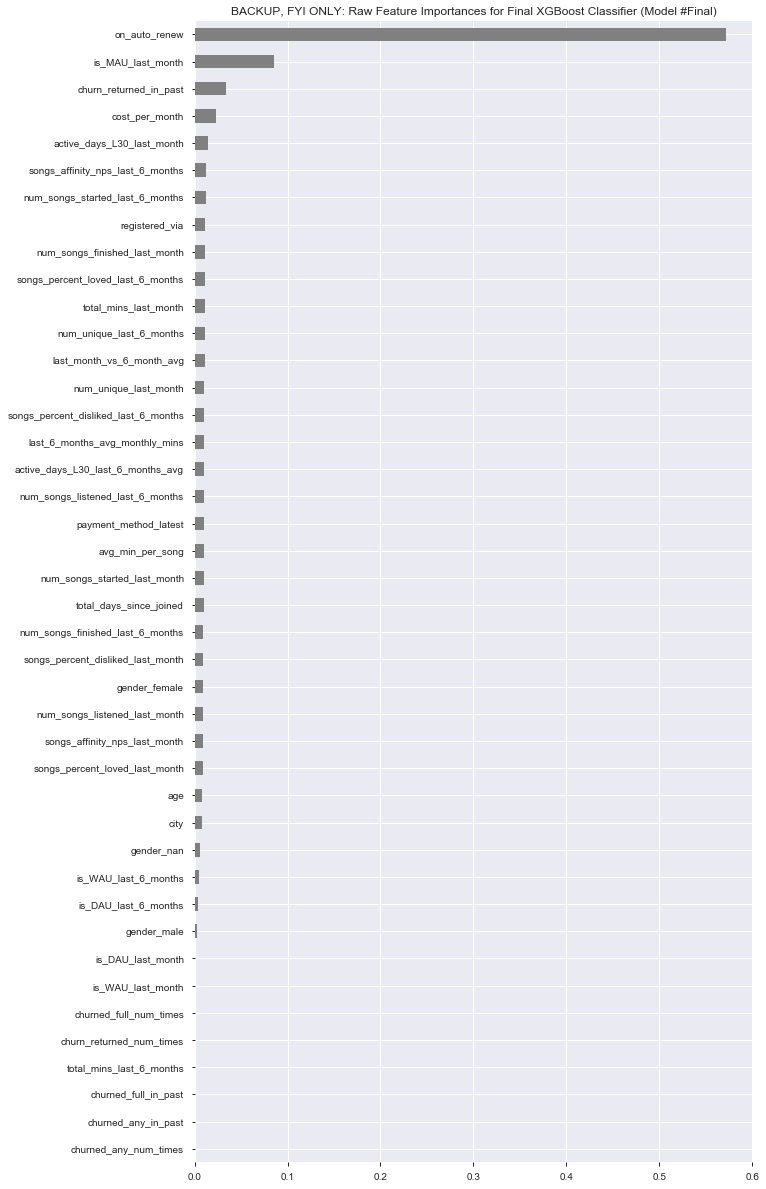

In [613]:
# BACKUP / FYI ONLY:

# Feature importances:
%matplotlib inline
import matplotlib.pyplot as plt

encoder = transformers.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
feat_importances_mfinal = pd.Series(mfinal.feature_importances_, encoded_columns)

# Plot on chart, sorted from most to least important:
n = len(encoded_columns)
plt.figure(figsize=(10, n/2))
feat_importances_mfinal.sort_values().plot.barh(color='grey')
plt.title('BACKUP, FYI ONLY: Raw Feature Importances for Final XGBoost Classifier (Model #Final)')
plt.show()

In [614]:
# To do:  Try setting (class_weight='balanced') in the estimator (e.g., LogisticRegressionCV) and/or consider different 
# class weights, to see if that would result in better predictive models (considering class imbalance in training data).

In [615]:
# Type of problem:  Classification + Regression Predicted Probability
# e.g., Churn:  “Which 5% of my customers will leave my business for a 
# competitor in the next year?” can be rephrased as “How likely is each 
# of my customers to leave my business for a competitor in the next year?”

# Core metric:  
# (1) Recall: maximize
# --> Our model's improvement in recall, as quantified in NT (and equivalent $$) amount!

# (2) False Negative Rate (FNR): minimize:

# [?? To do: also try out scoring with AUC, accuracy to cross check -- even though less important for this problem ??]

In [616]:
# e.g., Churn:  “Which 5% of my customers will leave my business for a competitor in the next year?” 
# can be rephrased as “How likely is each of my customers to leave my business for a competitor in the next year?”